In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

## Load Data

In [3]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [4]:
from src.load_data import load_data

data = load_data(epoch_key)

INFO:src.load_data:Loading position information and linearizing...
INFO:src.load_data:Loading multiunits...


In [5]:
from replay_trajectory_classification import ClusterlessDecoder

decoder = ClusterlessDecoder(transition_type='empirical_movement', replay_speed=400, place_bin_size=3)

In [6]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=3, position_range=None, replay_speed=400,
                   transition_type='empirical_movement')

In [7]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [8]:
place_bin_centers = decoder.place_bin_centers_

## Make State Transition

In [9]:
from scipy.interpolate import interp1d
import networkx as nx

track_graph1 = track_graph.copy()
n_nodes = len(track_graph.nodes)
n_bins = 100

for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
    xy = np.stack((xnew, f(xnew)), axis=1)
    dist = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    new_node_ids = n_nodes + np.arange(len(dist))
    nx.add_path(track_graph1, [node1, *new_node_ids, node2], distance=dist[0])
    track_graph1.remove_edge(node1, node2)
    for id, pos in zip(new_node_ids, xy):
        track_graph1.nodes[id]['pos'] = pos
        track_graph1.nodes[id]['track_segment_id'] = edge_ind
    track_graph1.nodes[node1]['track_segment_id'] = edge_ind
    track_graph1.nodes[node2]['track_segment_id'] = edge_ind
    n_nodes = len(track_graph1.nodes)

In [10]:
distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))

In [11]:
from src.load_data import convert_linear_distance_to_linear_position

node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
track_segment_id = np.array([ids[node_id] for node_id in node_ids])
linear_distance = np.array(linear_distance)

EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]
linear_position = convert_linear_distance_to_linear_position(
        linear_distance, track_segment_id, EDGE_ORDER, spacing=15)

close_ind = np.argmin(np.abs(linear_position - place_bin_centers), axis=1)
np.diff(np.stack((place_bin_centers.squeeze()[decoder.is_track_interior_], linear_position[close_ind][decoder.is_track_interior_]), axis=1)).squeeze()

array([ 0.0263248 ,  0.07897439, -0.03679031,  0.01585928,  0.06850887,
       -0.04725583,  0.56394832, -0.03402603, -0.08257728,  0.0520125 ,
        0.00346125, -0.04509   ,  0.08949978,  0.92802516,  0.0648259 ,
        0.01532221, -0.03418148,  0.07905395,  0.02955026, -0.99638812,
       -0.02304962, -0.05277476, -0.08249989,  0.06125043,  0.03152529,
        0.00180016,  1.66904044,  0.04290518, -0.06147355,  0.00323179,
        0.06793713, -0.0364416 ,  0.02826374,  0.64147717, -0.06204818,
        0.04702733, -0.00641734, -0.05986201,  0.04921349, -1.14187237,
       -0.00830591, -0.07556558,  0.02844228, -0.03881739,  0.06519047,
       -0.0020692 ,  1.13149726,  0.02792935, -0.05278047,  0.03698606,
       -0.04372376,  0.04604276, -0.03466706,  0.24177055,  0.07038325,
        0.06413832,  0.0578934 ,  0.05164847,  0.04540355])

In [117]:
from scipy.stats import multivariate_normal
from src.load_data import convert_linear_distance_to_linear_position
from scipy.ndimage import label
from replay_trajectory_classification.state_transition import _normalize_row_probability

EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]
    
    
def make_state_transition(track_graph, place_bin_centers, center_well_id,
                          is_track_interior, edge_order, edge_spacing,
                          replay_speed=1, movement_var=64):
    
    track_graph1 = track_graph.copy()
    n_nodes = len(track_graph.nodes)
    n_bins = 100

    for edge_ind, (node1, node2) in enumerate(track_graph.edges):
        node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
        node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
        f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
        xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
        xy = np.stack((xnew, f(xnew)), axis=1)
        dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)

        new_node_ids = n_nodes + np.arange(len(dist_between_nodes) + 1)
        nx.add_path(track_graph1, [*new_node_ids], distance=dist_between_nodes[0])
        nx.add_path(track_graph1, [node1, new_node_ids[0]], distance=0)
        nx.add_path(track_graph1, [node2, new_node_ids[-1]], distance=0)
        track_graph1.remove_edge(node1, node2)
        for ind, (node_id, pos) in enumerate(zip(new_node_ids, xy)):
            track_graph1.nodes[node_id]['pos'] = pos
            track_graph1.nodes[node_id]['track_segment_id'] = edge_ind
        track_graph1.nodes[node1]['track_segment_id'] = edge_ind
        track_graph1.nodes[node2]['track_segment_id'] = edge_ind
        n_nodes = len(track_graph1.nodes)
        
    distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))
    
    node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
    ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
    track_segment_id = np.array([ids[node_id] for node_id in node_ids])
    linear_distance = np.array(linear_distance)

    linear_position = convert_linear_distance_to_linear_position(
            linear_distance, track_segment_id, edge_order, spacing=edge_spacing)

    close_ind = np.argmin(np.abs(linear_position - place_bin_centers), axis=1)

    state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))
    gaussian = multivariate_normal(
            mean=0, cov=movement_var * replay_speed)

    for bin_ind1, node_ind1 in enumerate(close_ind):
        for bin_ind2, node_ind2 in enumerate(close_ind):
            state_transition[bin_ind1, bin_ind2] = gaussian.pdf(
                    distance[node_ids[node_ind1]][node_ids[node_ind2]])

    state_transition[~is_track_interior] = 0
    state_transition[:, ~is_track_interior] = 0
    
    state_transition = _normalize_row_probability(state_transition)
    node_to_bin = np.array([node_ids[ind] for ind in close_ind])
    
    return state_transition, track_graph1, node_to_bin

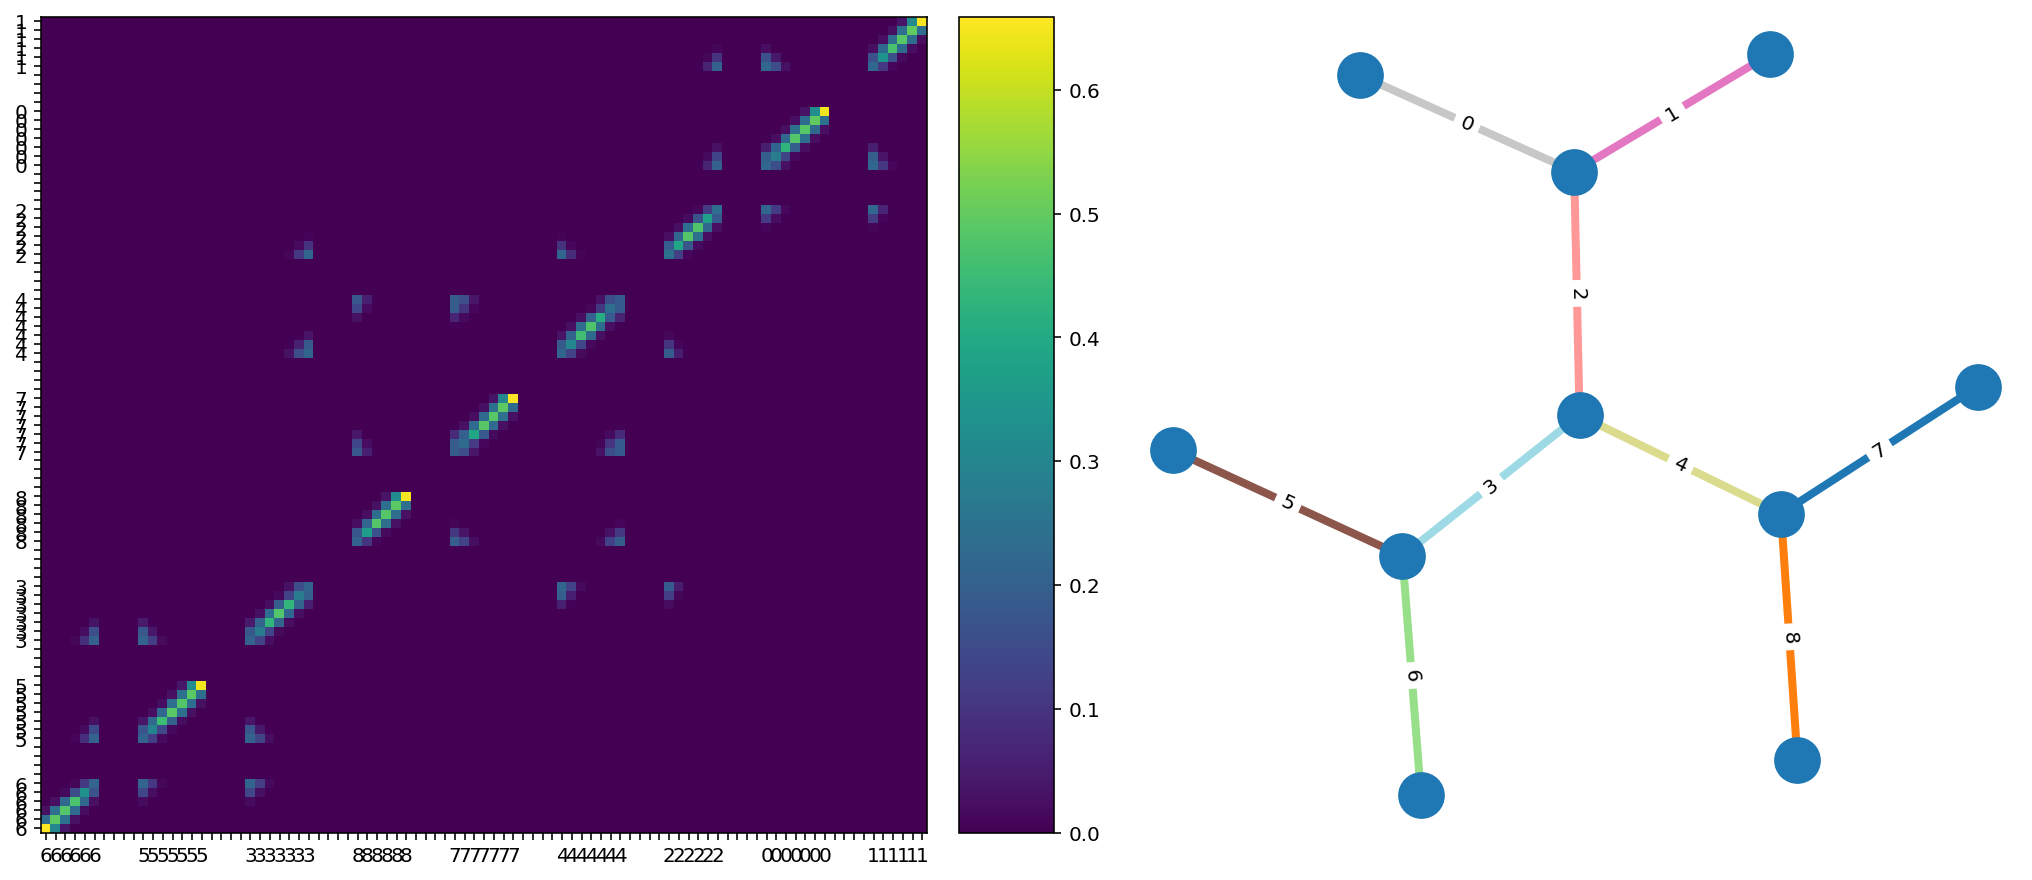

In [118]:
from scipy.ndimage import label

state_transition, track_graph1, node_to_bin = make_state_transition(
    track_graph, place_bin_centers, center_well_id=7,
    is_track_interior=decoder.is_track_interior_, edge_order=EDGE_ORDER,
    edge_spacing=15, replay_speed=1, movement_var=6)

labels, _ = label(decoder.is_track_interior_)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f'{EDGE_ORDER[label-1]}')
    else:
        bin_edge.append('')


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(state_transition)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');

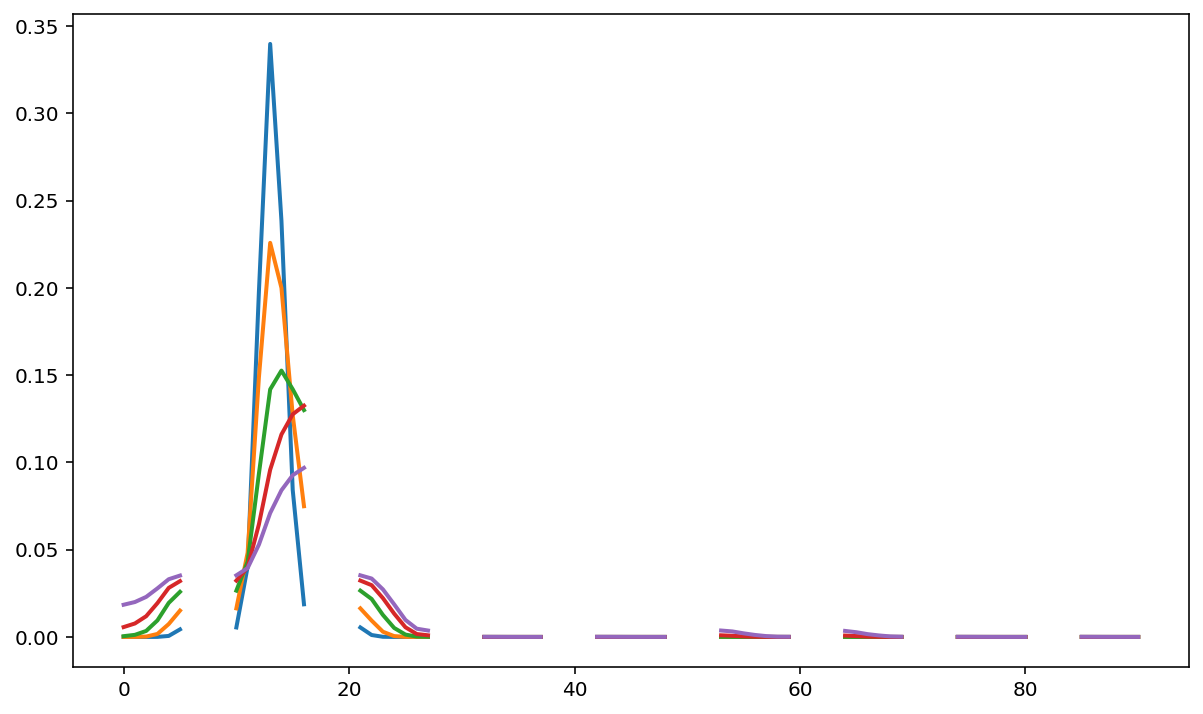

In [119]:
mask = np.ones_like(place_bin_centers).squeeze()
mask[~decoder.is_track_interior_] = np.nan

fig, ax = plt.subplots(figsize=(10, 6))
for speedup in [2, 4, 8, 16, 32]:
    ax.plot(np.linalg.matrix_power(state_transition.T, speedup)[13] * mask, linewidth=2);

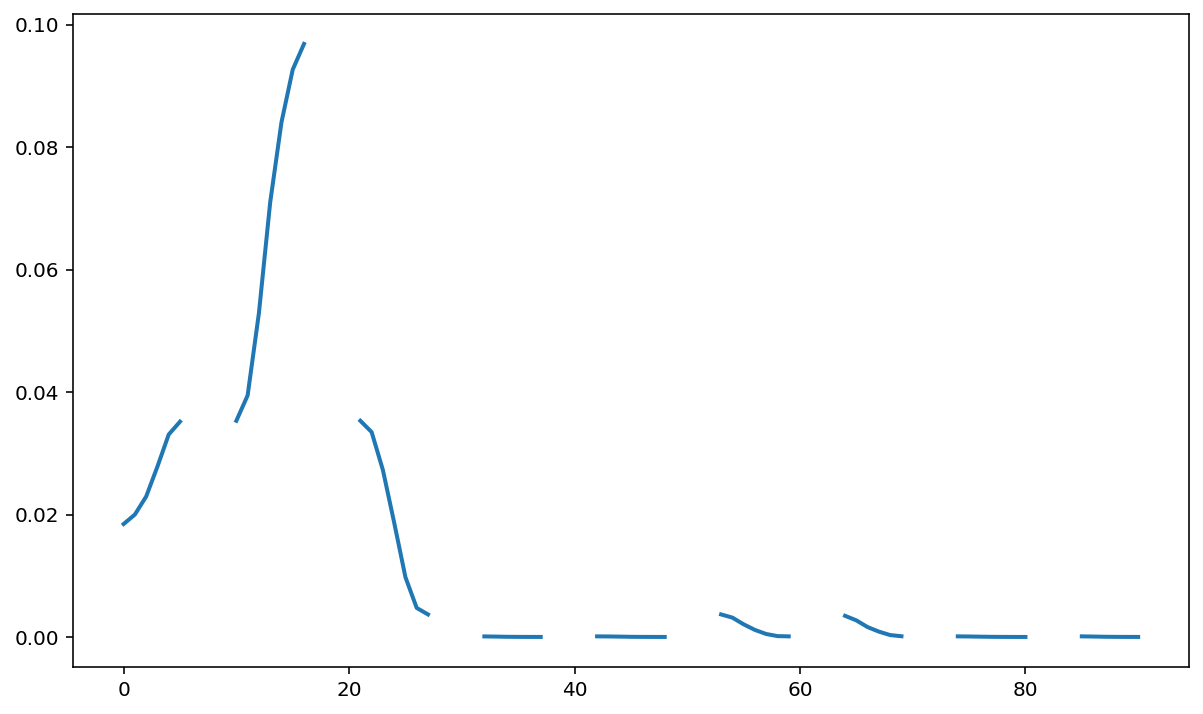

In [120]:
from ipywidgets import interact

@interact(speedup=(1, 64))
def _plot_transition(speedup):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.linalg.matrix_power(state_transition.T, speedup)[13] * mask, linewidth=2);

In [121]:
import holoviews as hv
import xarray as xr

hv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [122]:
images = np.stack([np.linalg.matrix_power(state_transition.T, speedup)[13] * mask
                   for speedup in range(1, 1000, 2)]).squeeze()
images = xr.DataArray(images, dims=['time', 'position'], name='Probability',
                      coords=[range(1, 1000, 2), place_bin_centers.squeeze()])
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ['position']).options(fig_inches=(10, 5))

In [123]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpk5sl4j9u.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)

In [124]:
images = np.stack([np.linalg.matrix_power(state_transition.T, speedup)[47] * mask
                   for speedup in range(1, 1000, 2)]).squeeze()
images = xr.DataArray(images, dims=['time', 'position'], name='Probability',
                      coords=[range(1, 1000, 2), place_bin_centers.squeeze()])
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ['position']).options(fig_inches=(10, 5))

In [125]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpy_21jzxv.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)

In [126]:
decoder.is_track_interior_[75]

True

In [127]:
images = np.stack([np.linalg.matrix_power(state_transition.T, speedup)[75] * mask
                   for speedup in range(1, 1000, 2)]).squeeze()
images = xr.DataArray(images, dims=['time', 'position'], name='Probability',
                      coords=[range(1, 1000, 2), place_bin_centers.squeeze()])
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ['position']).options(fig_inches=(10, 5))

In [128]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmps9ftenfd.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)

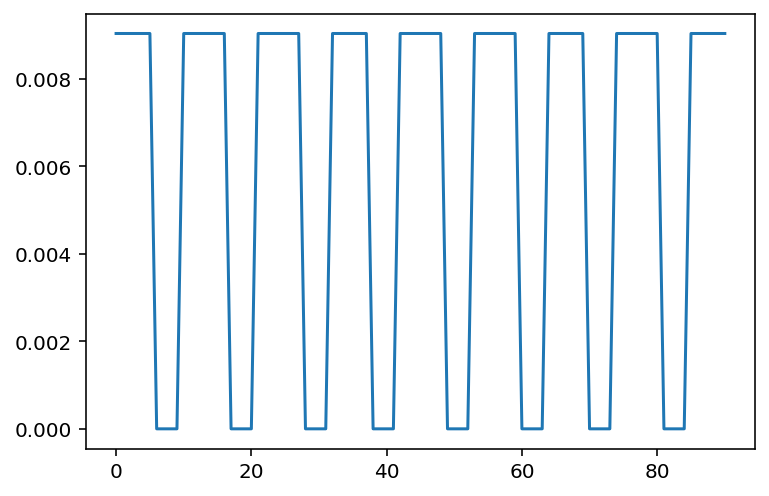

In [129]:
plt.plot(np.linalg.matrix_power(state_transition.T, 10000)[0])

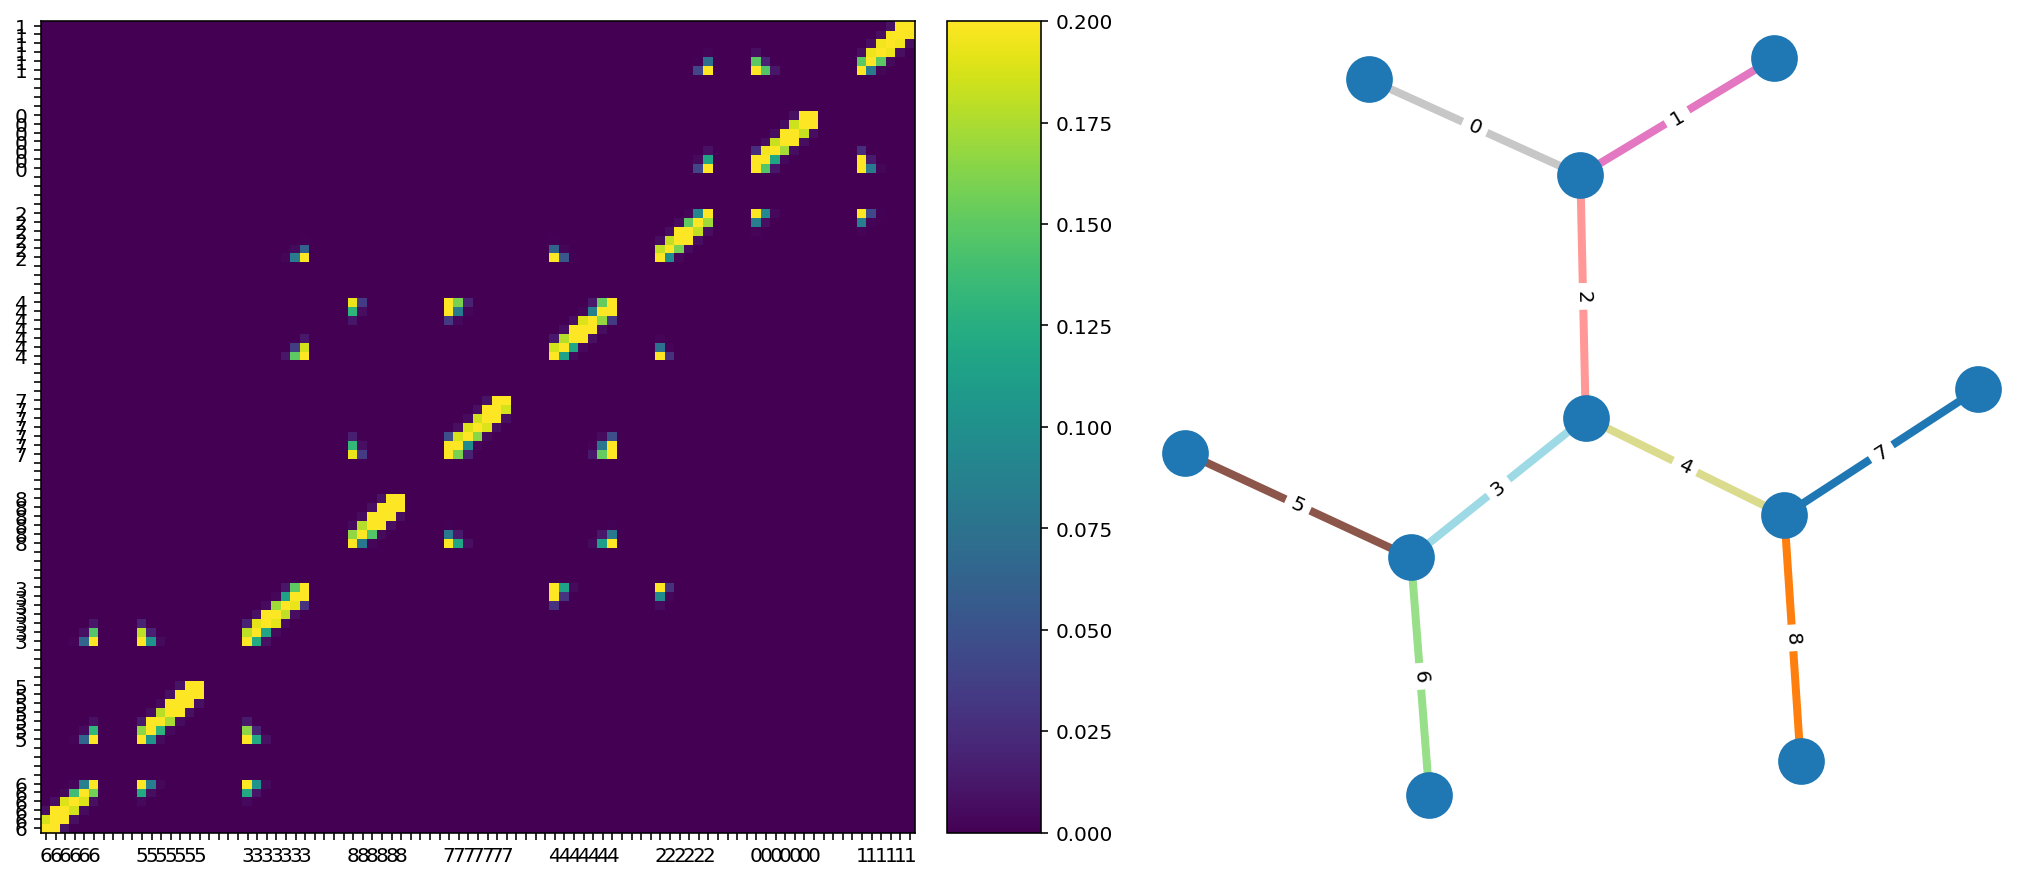

In [130]:
from scipy.ndimage import label

state_transition, track_graph1, node_to_bin = make_state_transition(
    track_graph, place_bin_centers, center_well_id=7,
    is_track_interior=decoder.is_track_interior_, edge_order=EDGE_ORDER,
    edge_spacing=15, replay_speed=1, movement_var=4)

labels, _ = label(decoder.is_track_interior_)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f'{EDGE_ORDER[label-1]}')
    else:
        bin_edge.append('')


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(state_transition, vmin=0.0, vmax=0.2)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');

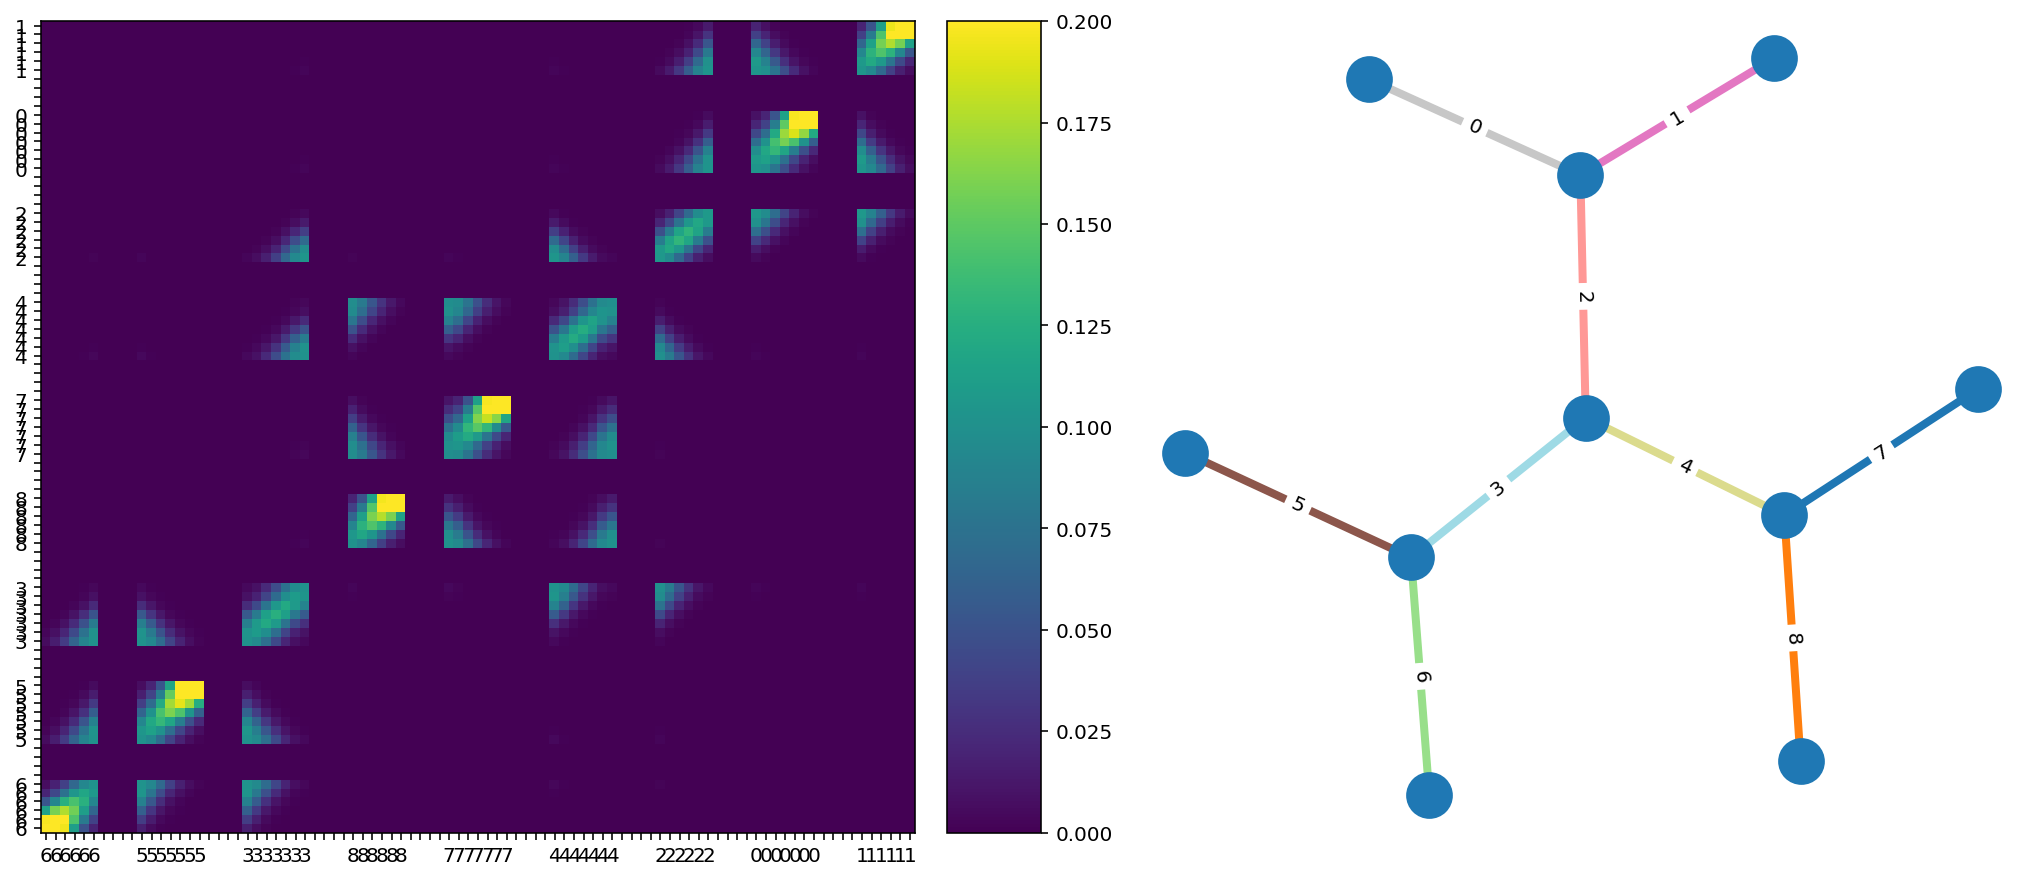

In [131]:
from scipy.ndimage import label

state_transition, track_graph1, node_to_bin = make_state_transition(
    track_graph, place_bin_centers, center_well_id=7,
    is_track_interior=decoder.is_track_interior_, edge_order=EDGE_ORDER,
    edge_spacing=15, replay_speed=1, movement_var=40)

labels, _ = label(decoder.is_track_interior_)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f'{EDGE_ORDER[label-1]}')
    else:
        bin_edge.append('')


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(state_transition, vmin=0.0, vmax=0.2)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');

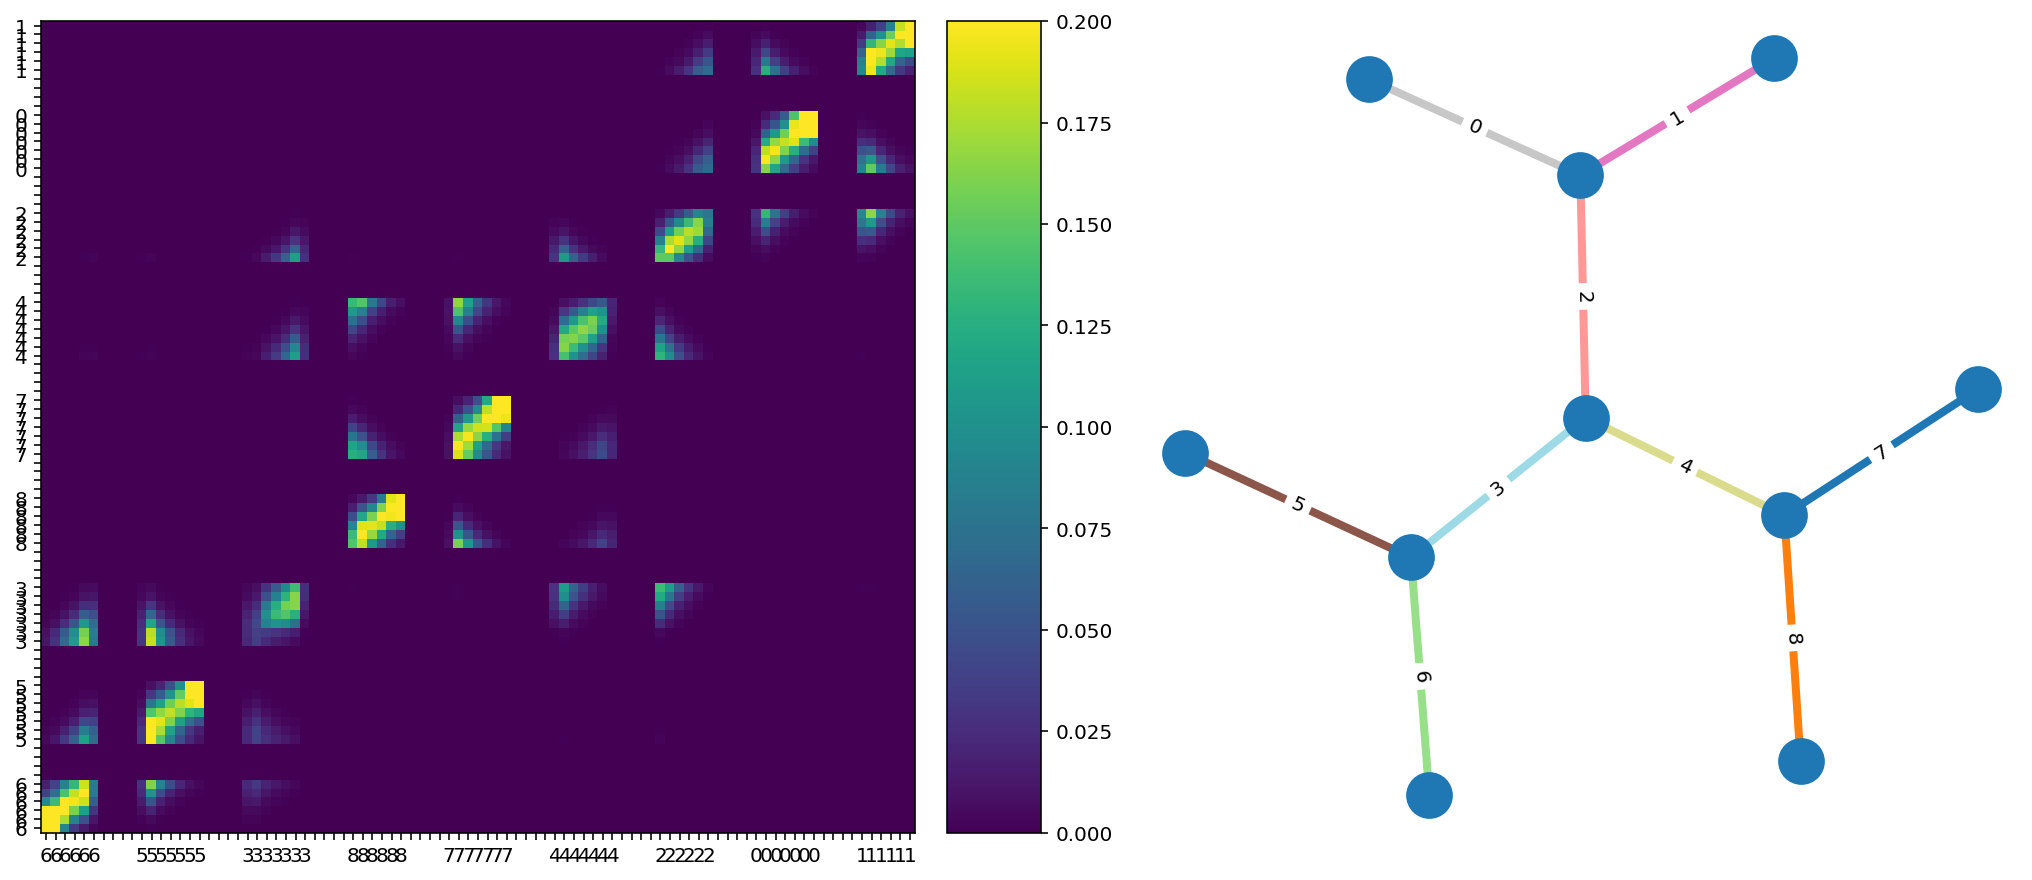

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(decoder.state_transition_, vmin=0.0, vmax=0.2)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0]);

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[1],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
plt.axis('off');

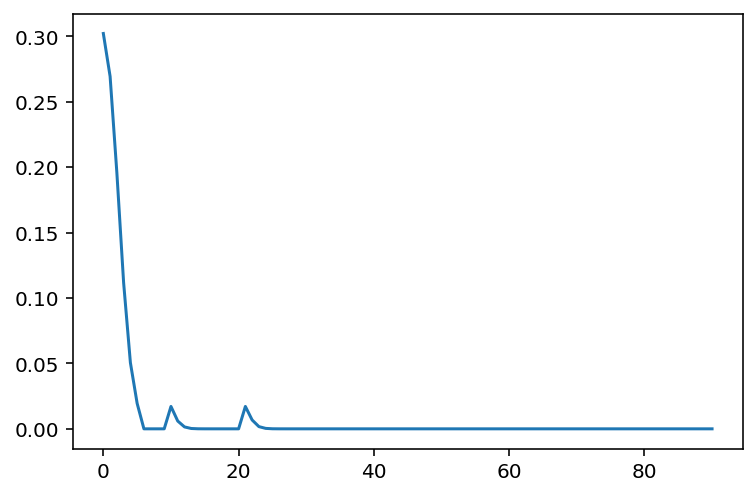

In [133]:
plt.plot(state_transition[0])

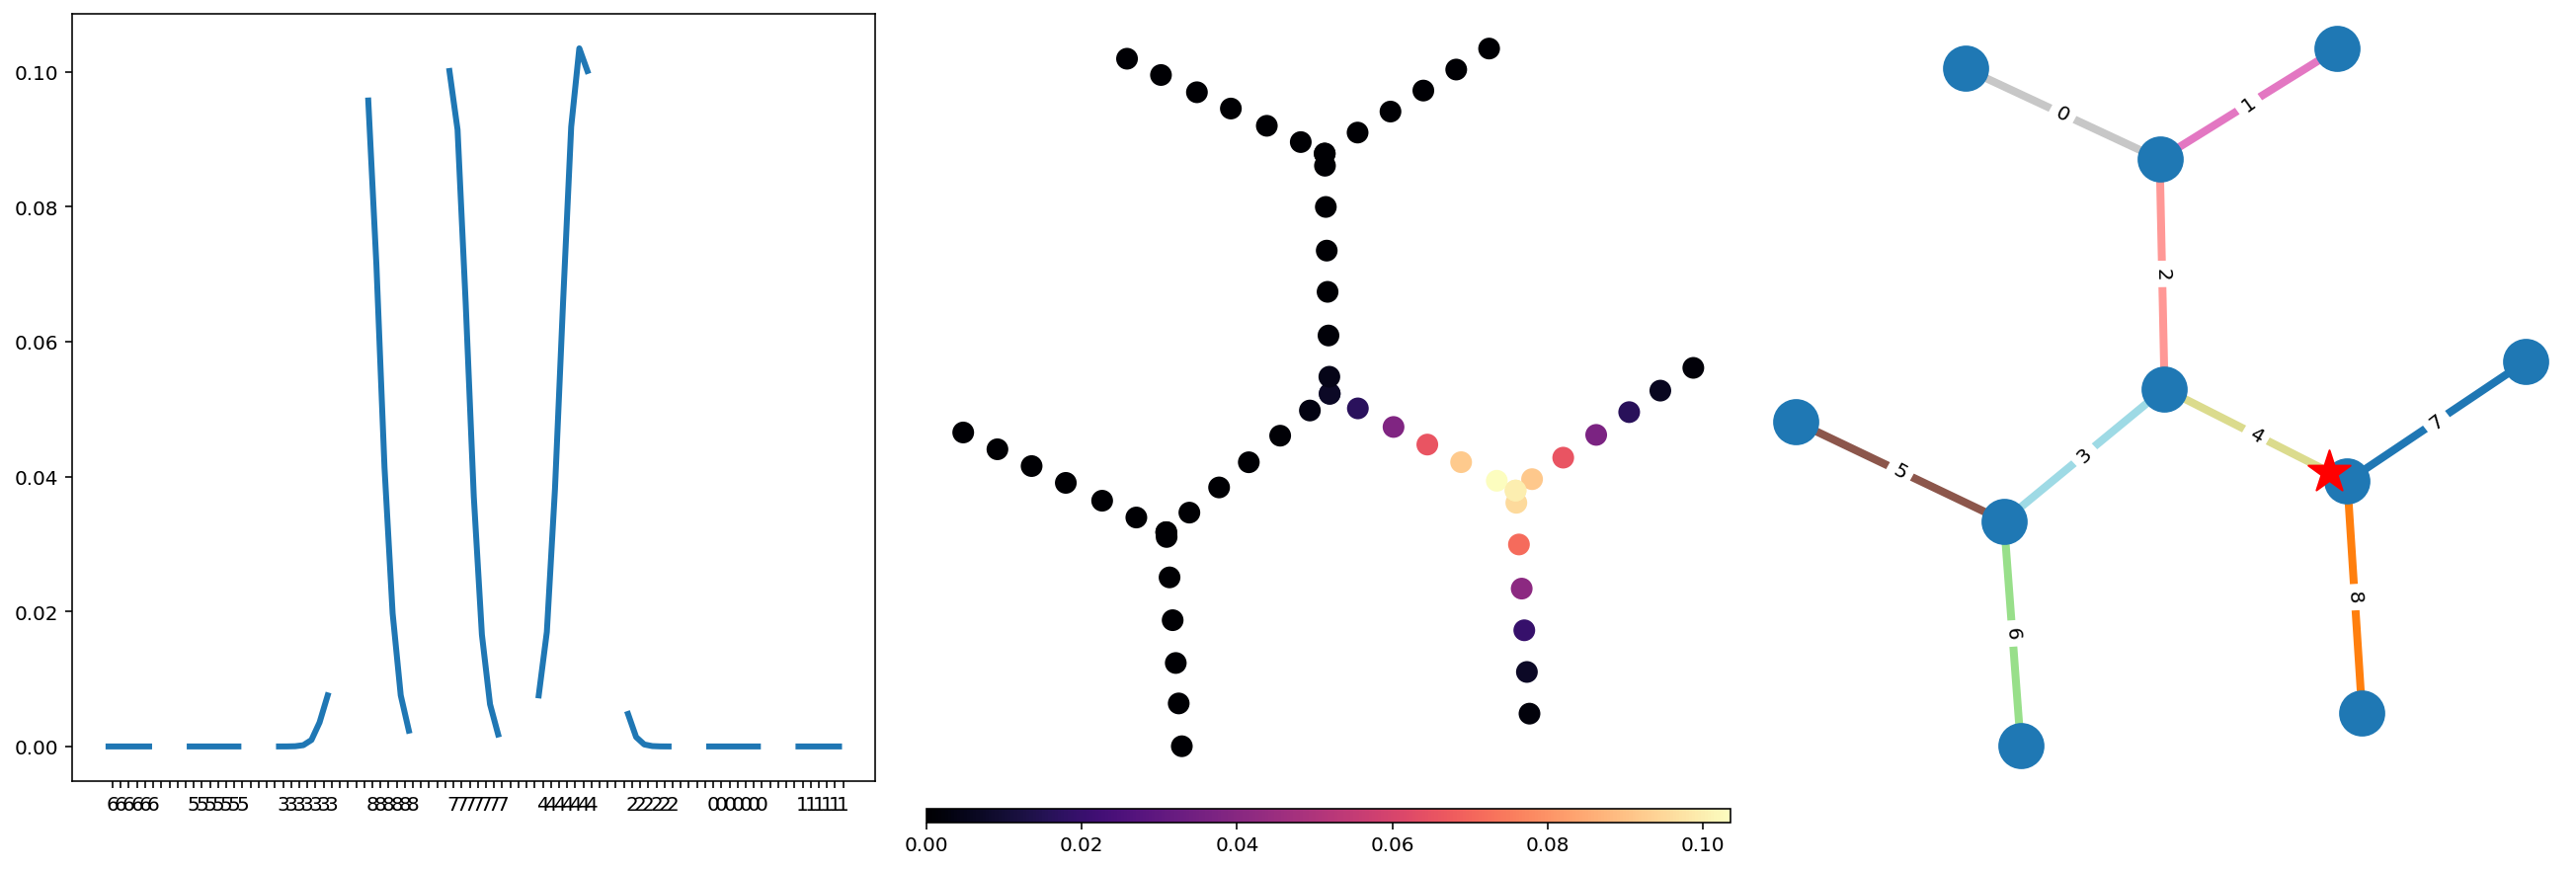

In [134]:
place_bin_centers_2D = np.stack([track_graph1.nodes[node]['pos'] for node in node_to_bin[decoder.is_track_interior_]])

bin_ind = 58

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

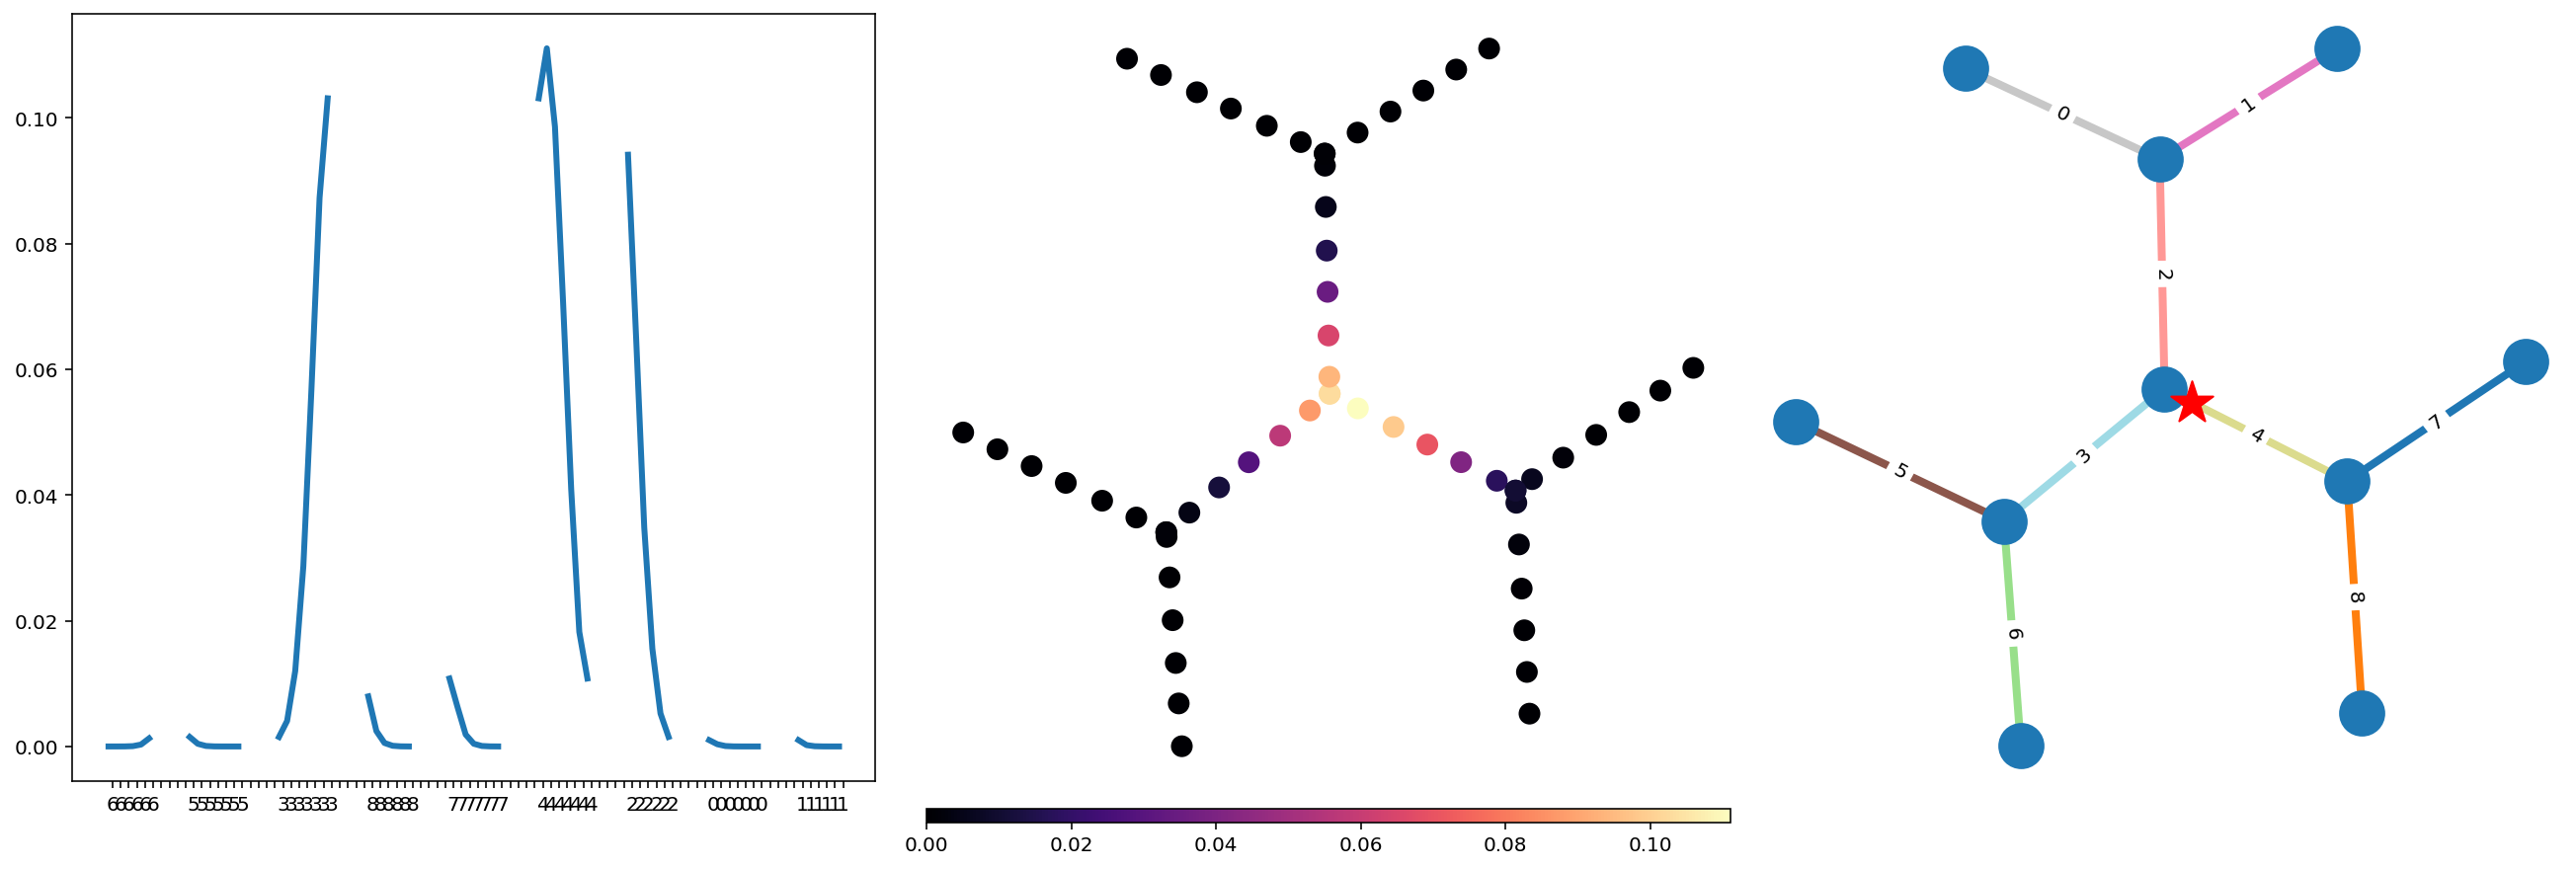

In [135]:
bin_ind = 54

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

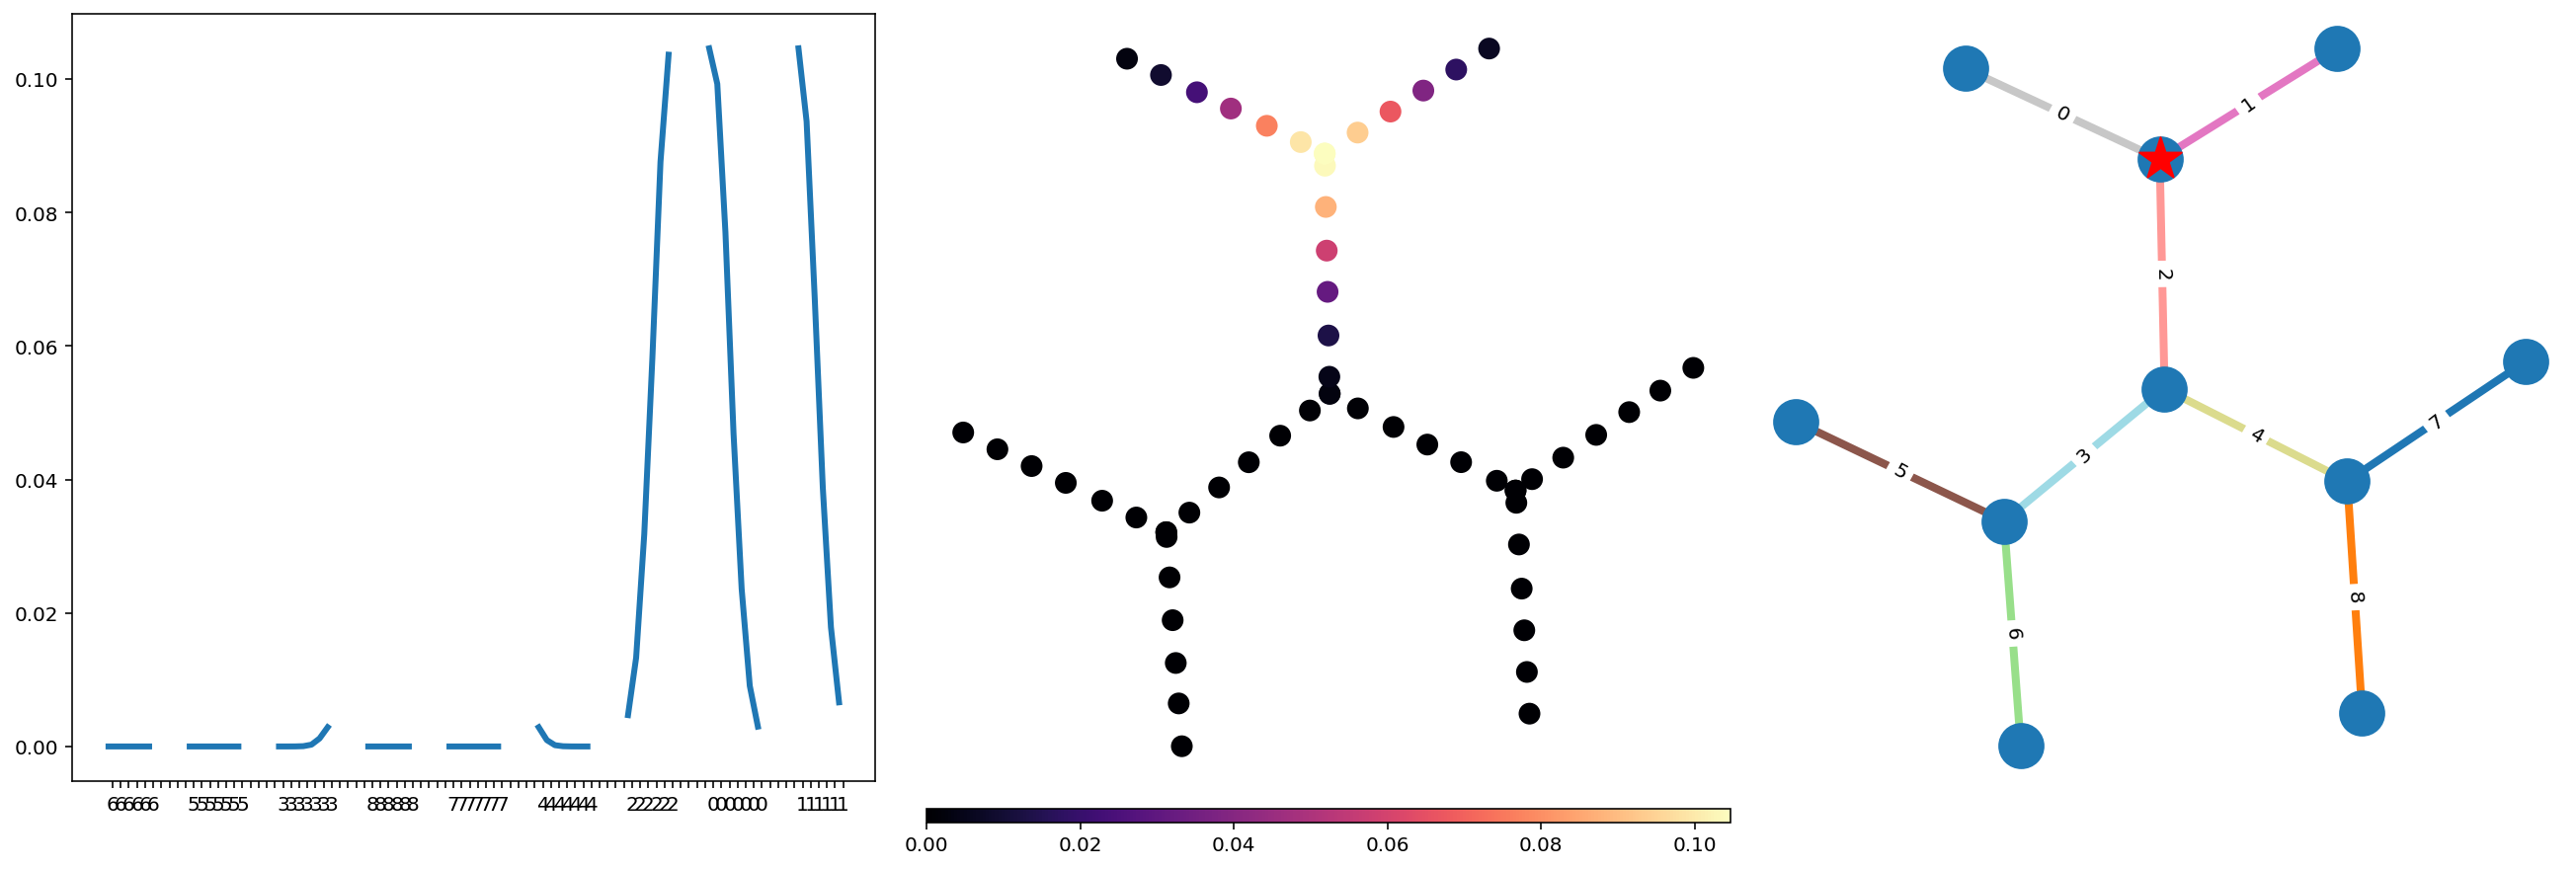

In [136]:
bin_ind = 74

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
axes[2].axis('off');

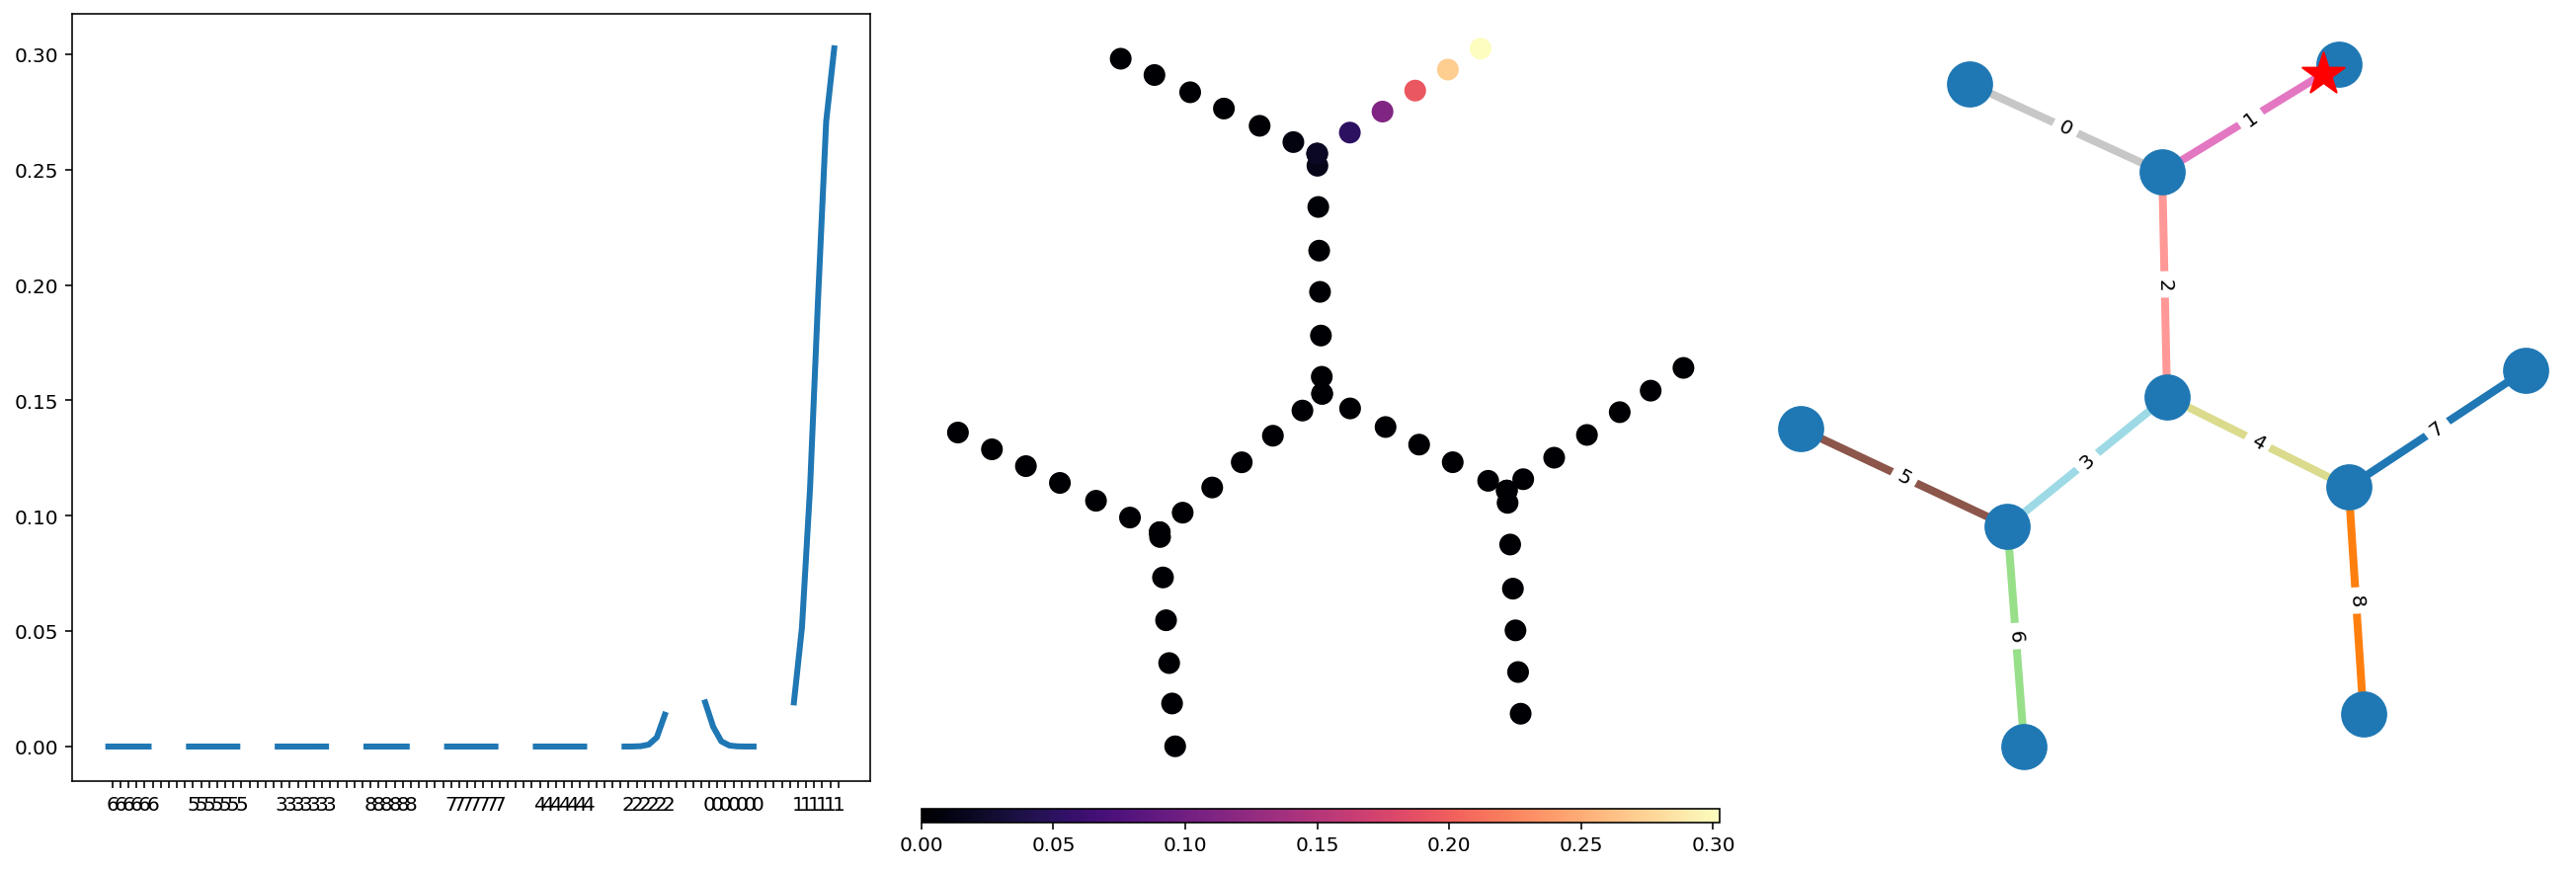

In [137]:
bin_ind = 90

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

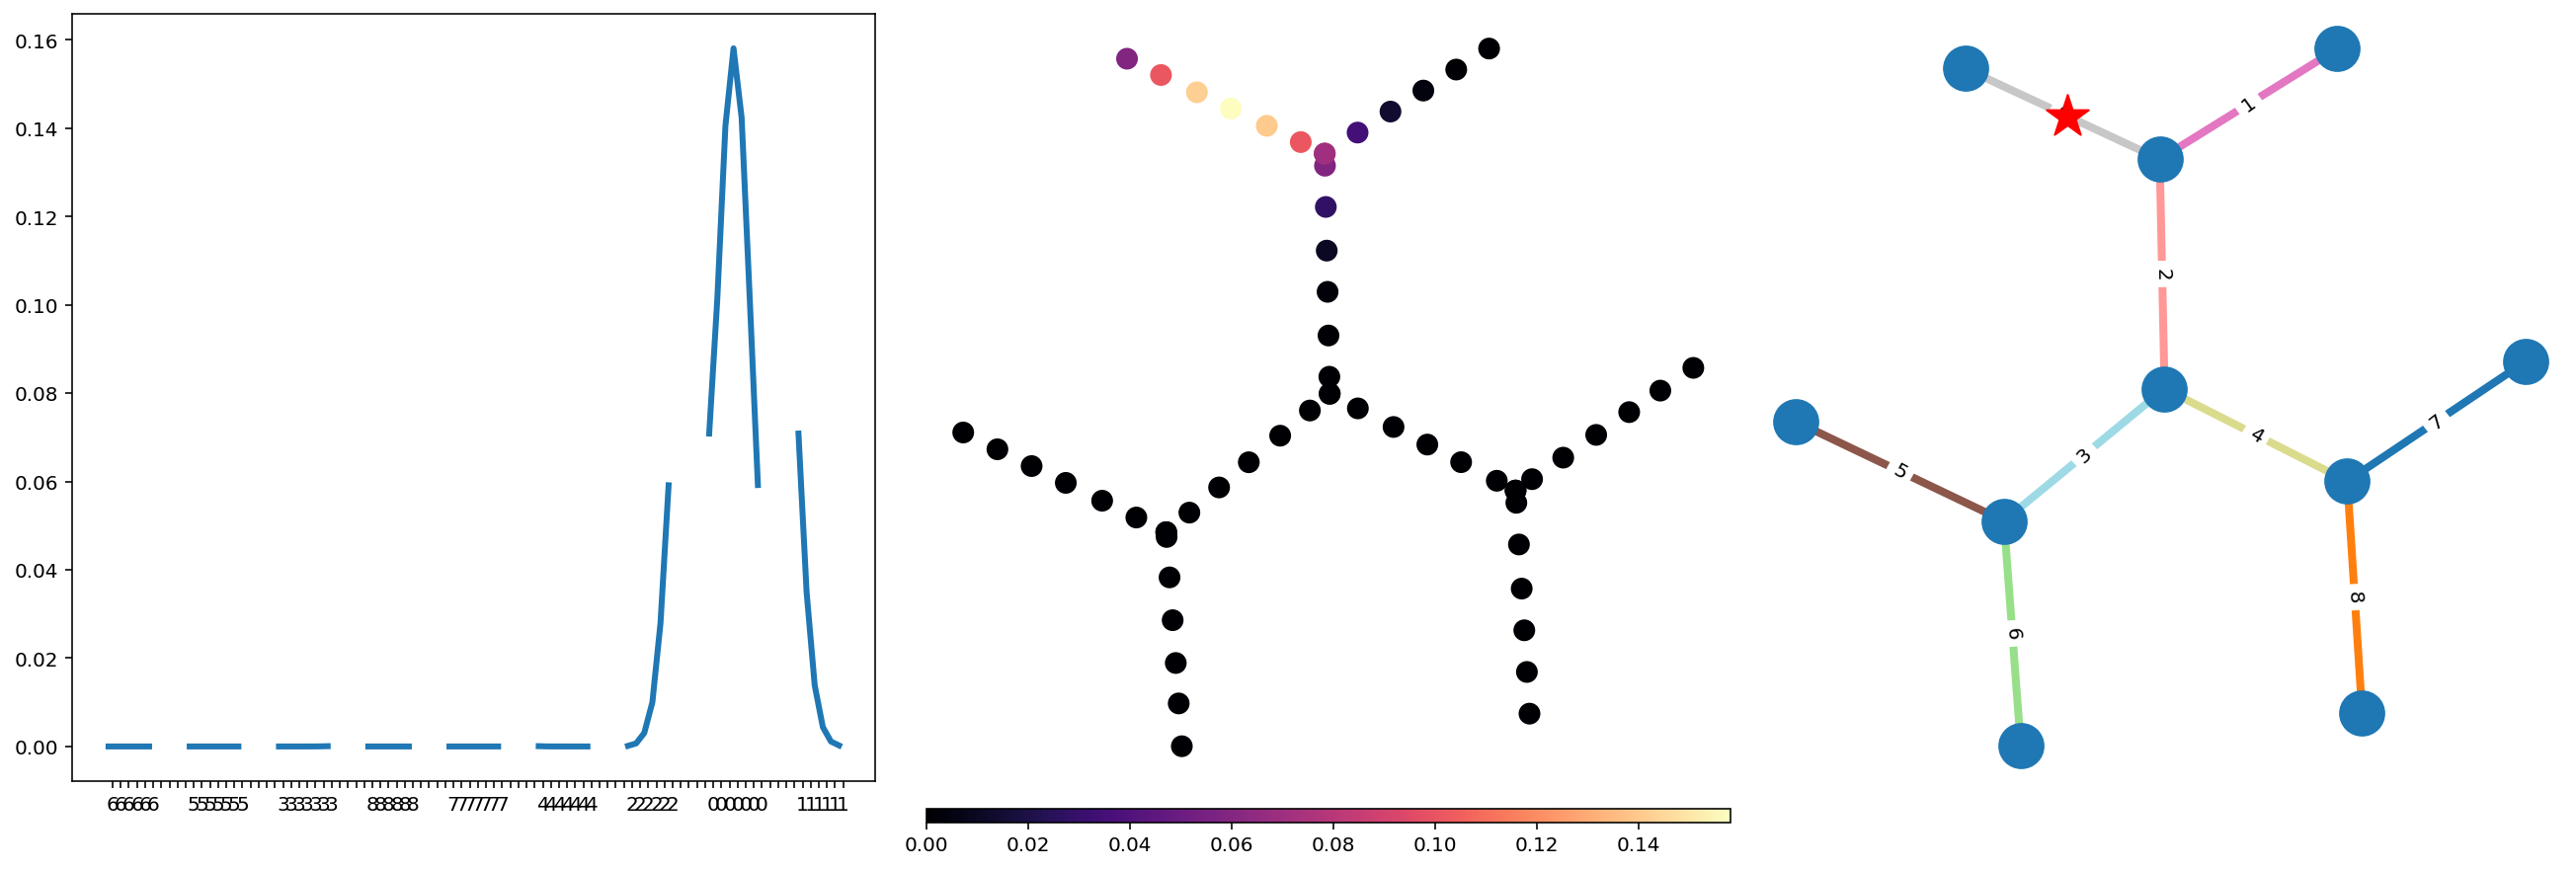

In [138]:
bin_ind = 77

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

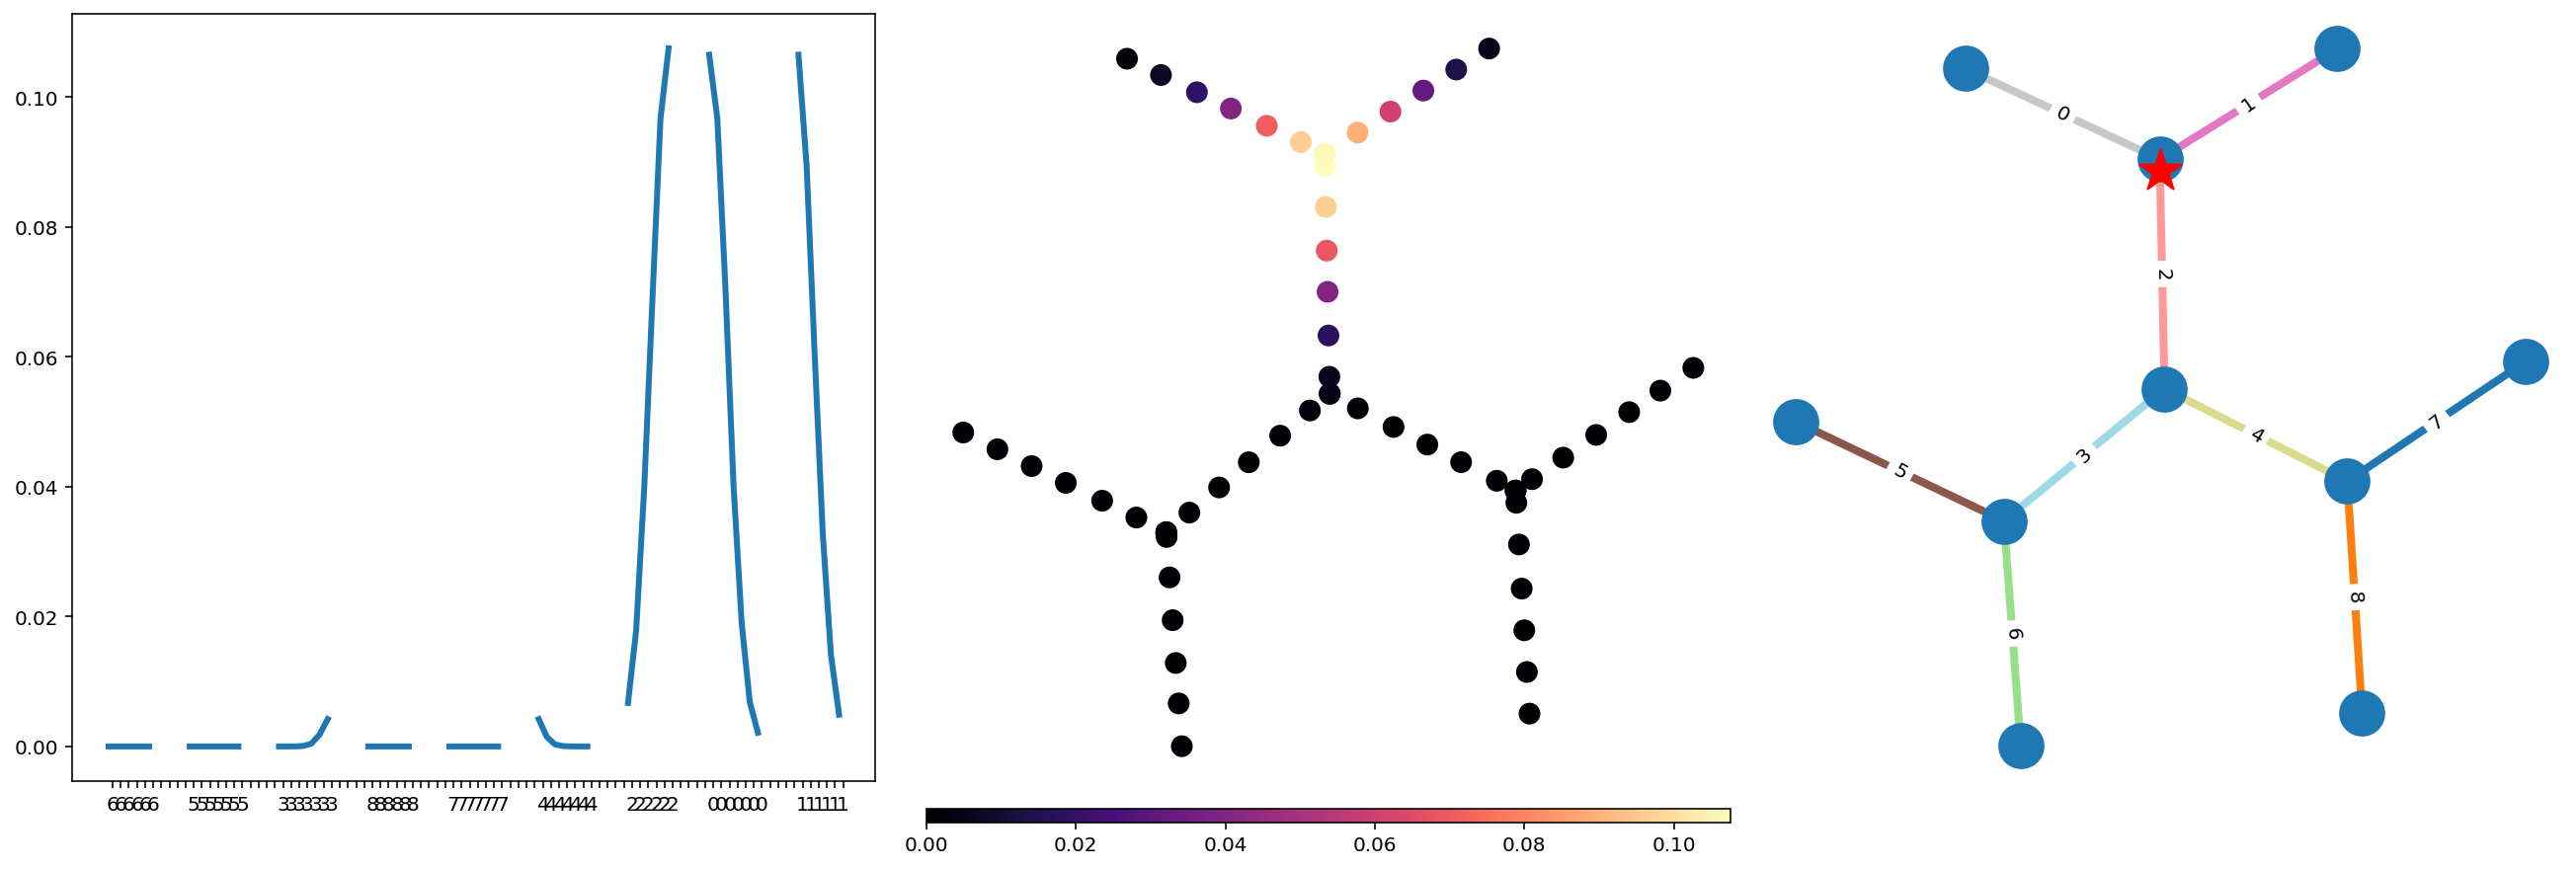

In [139]:
bin_ind = 69

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

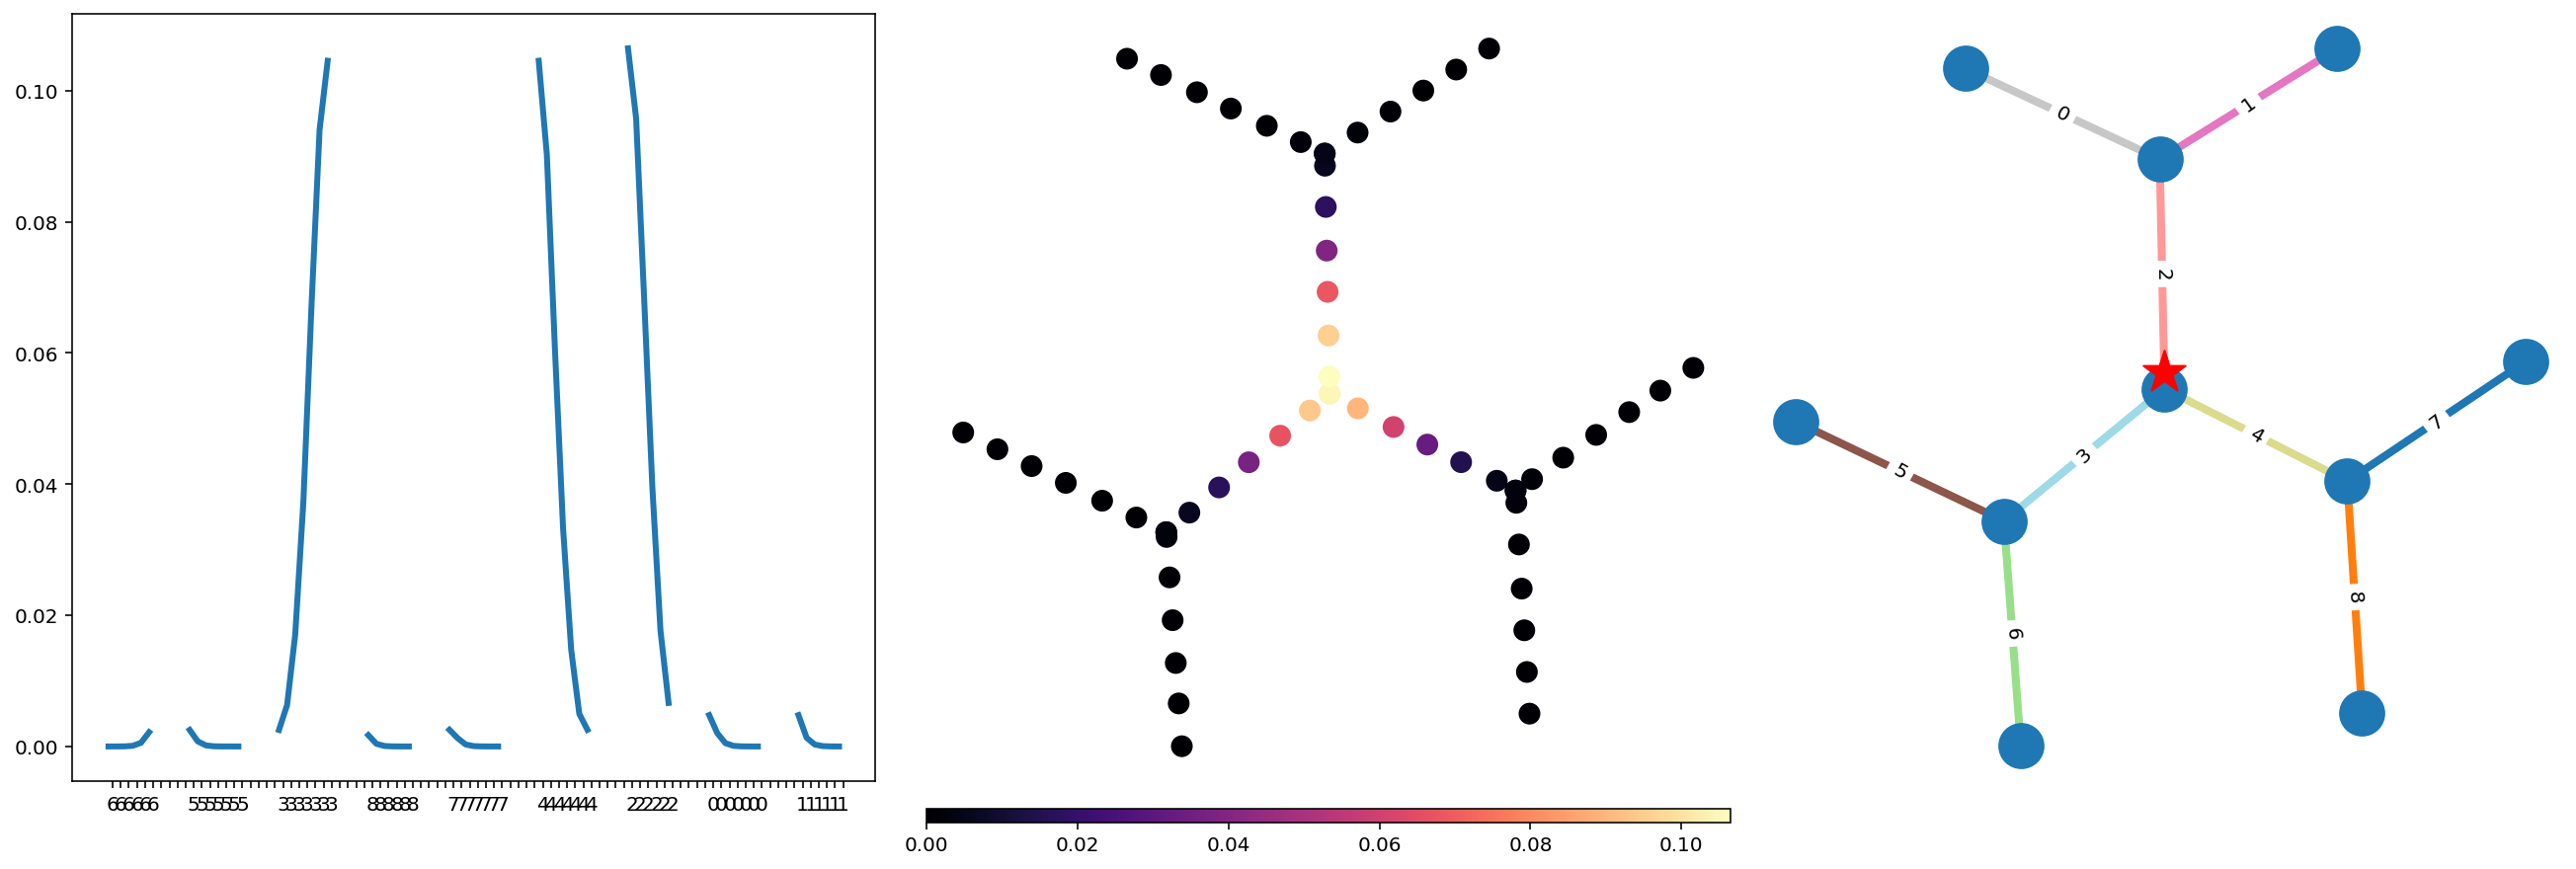

In [140]:
bin_ind = 64

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

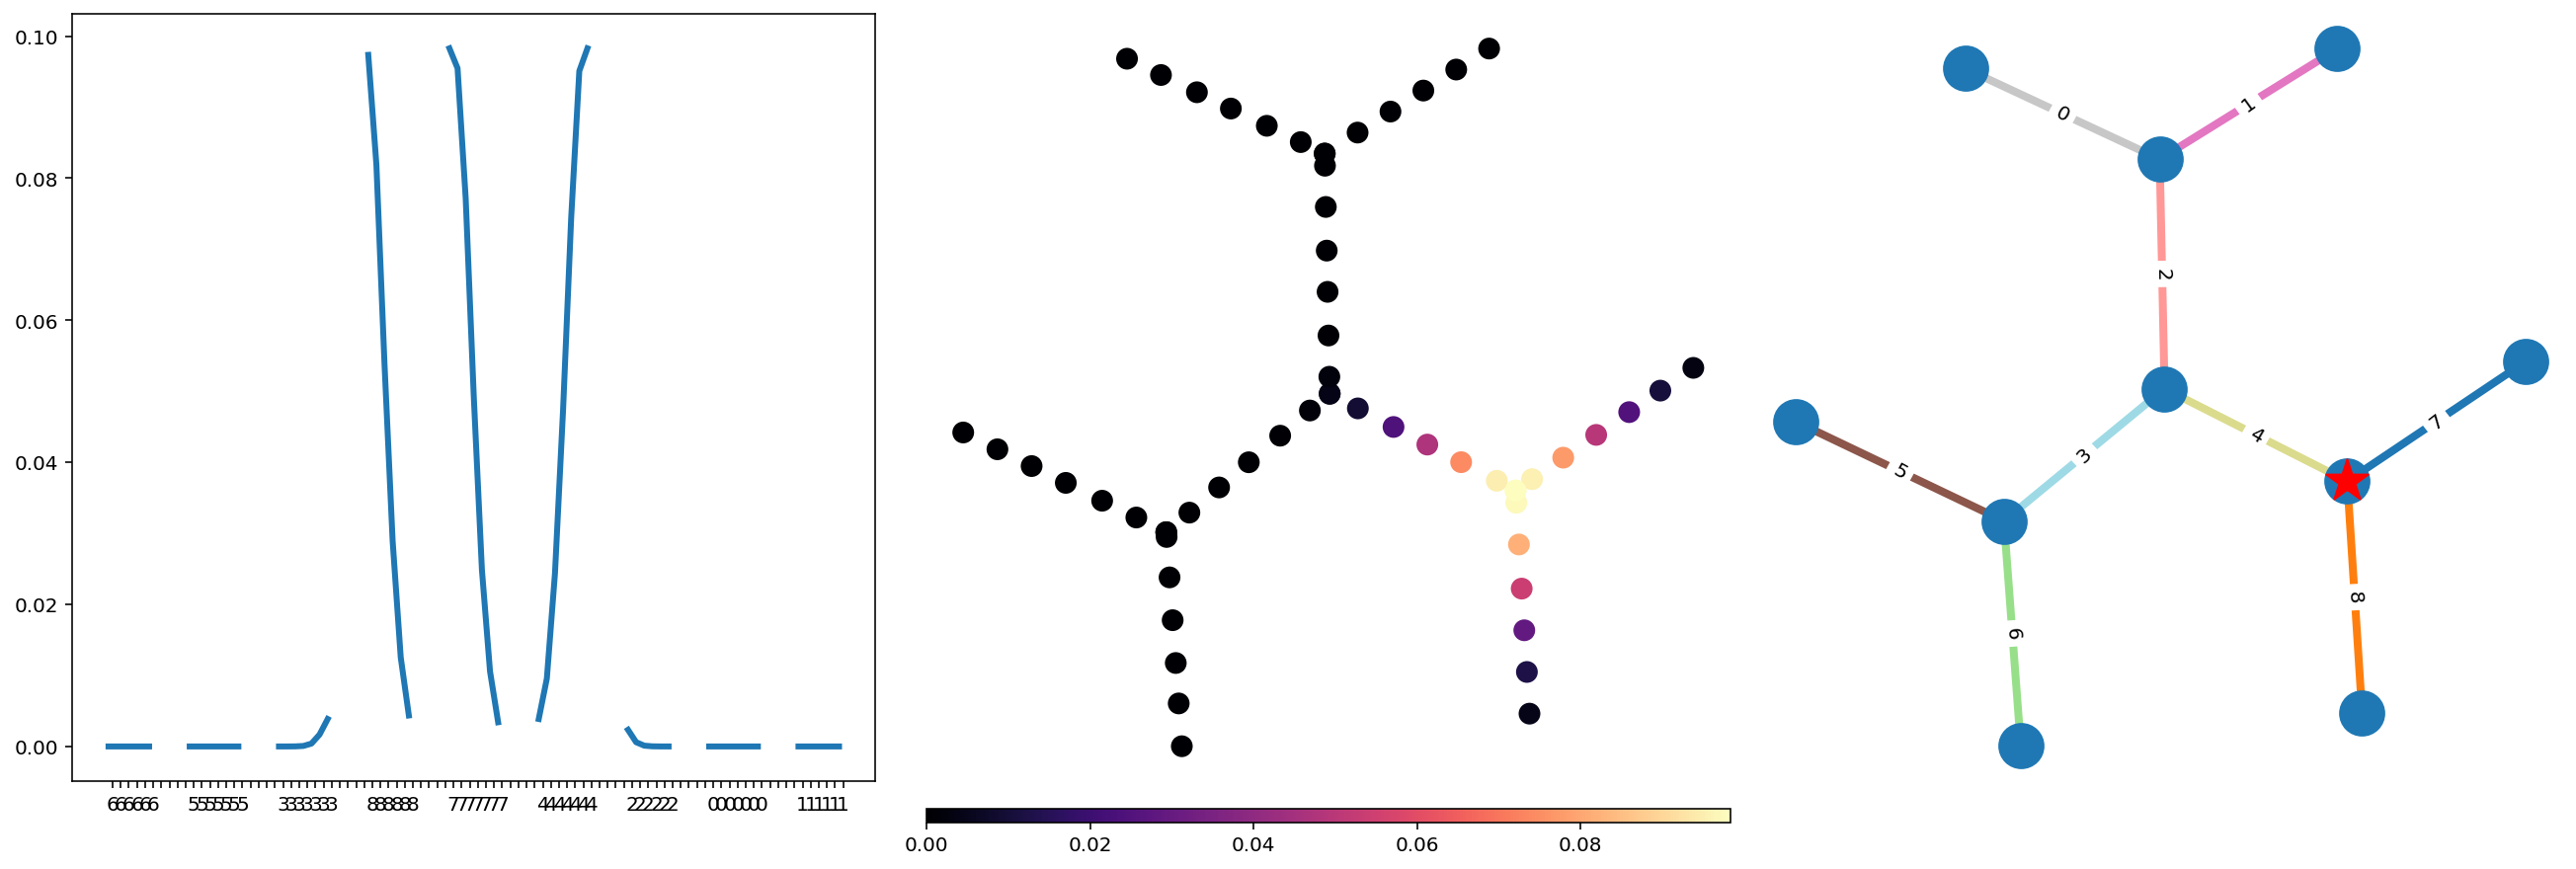

In [141]:
bin_ind = 59

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

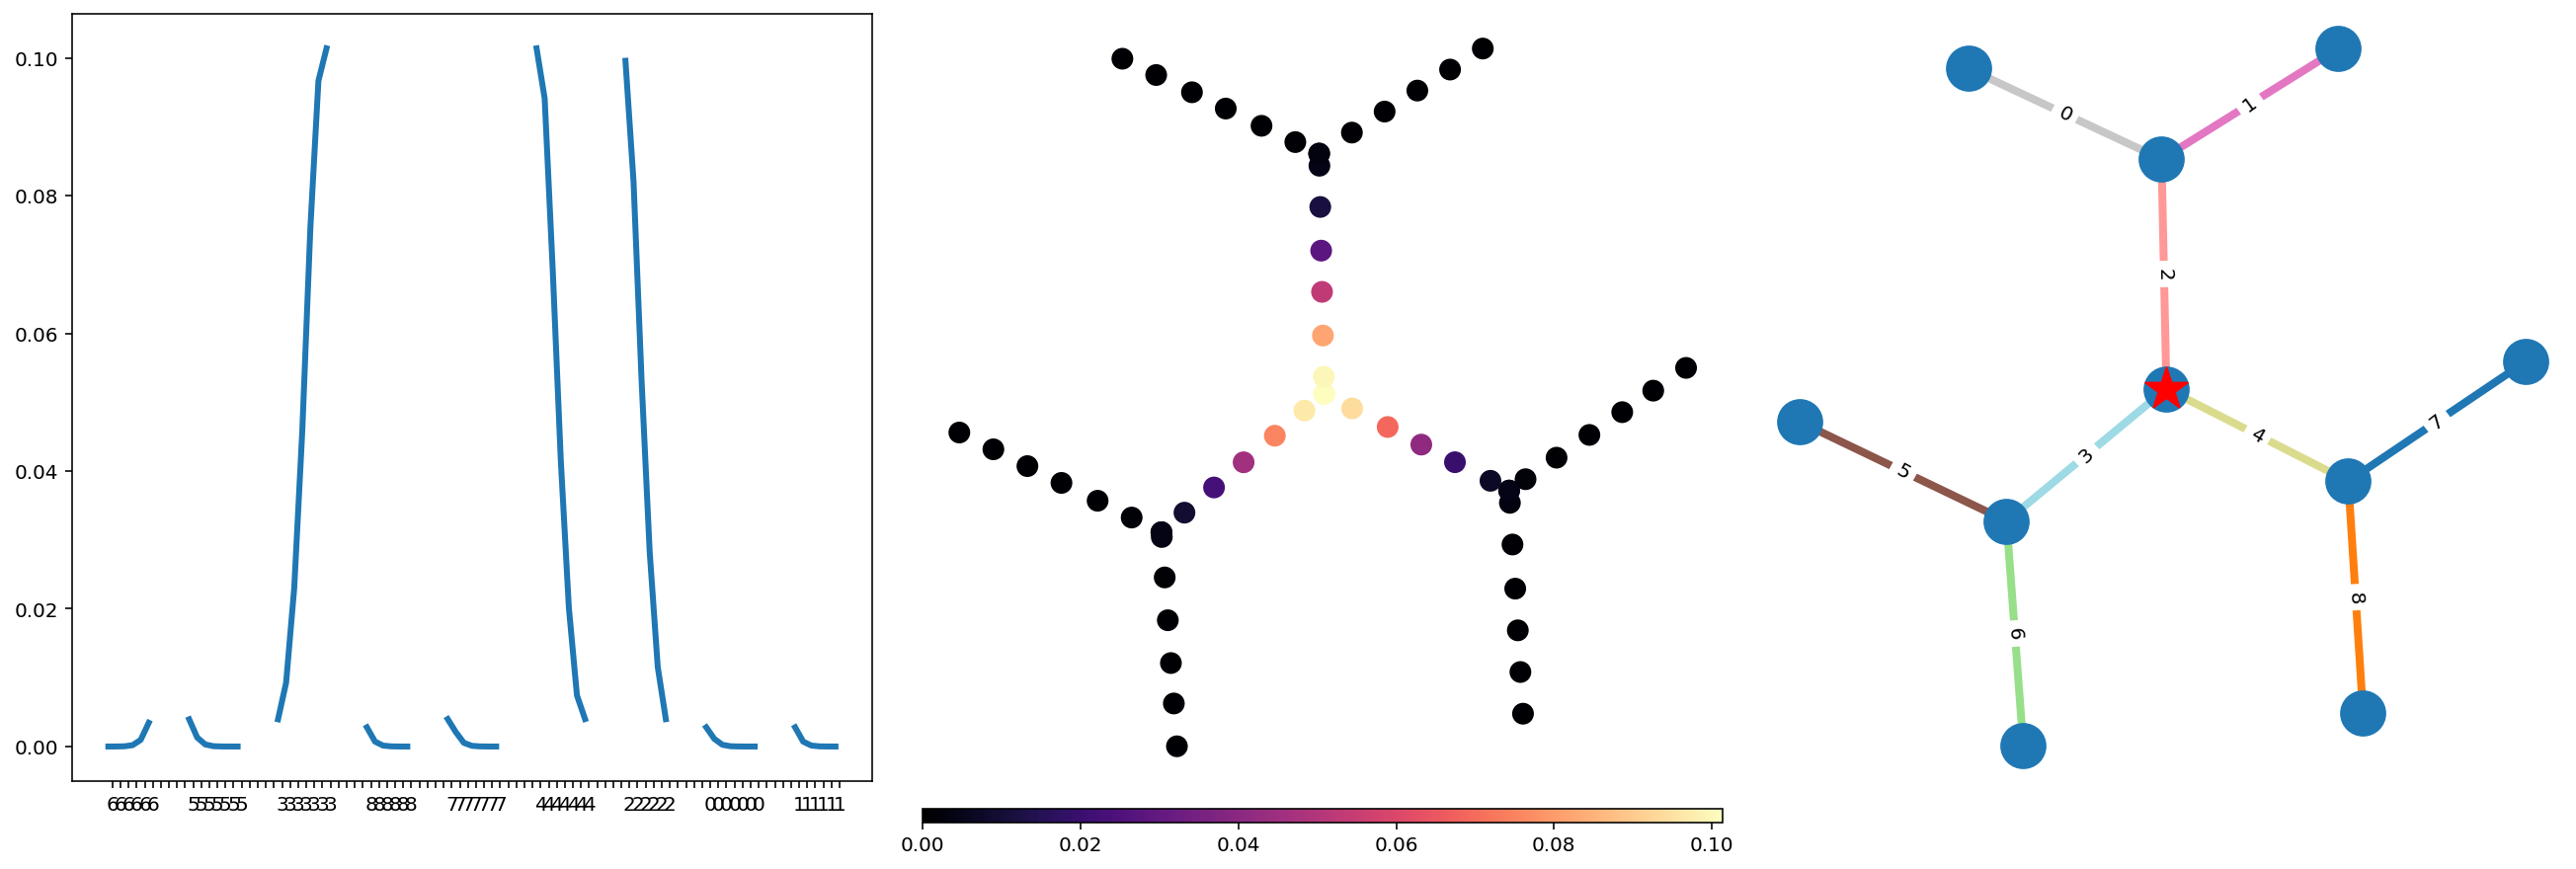

In [142]:
bin_ind = 53

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

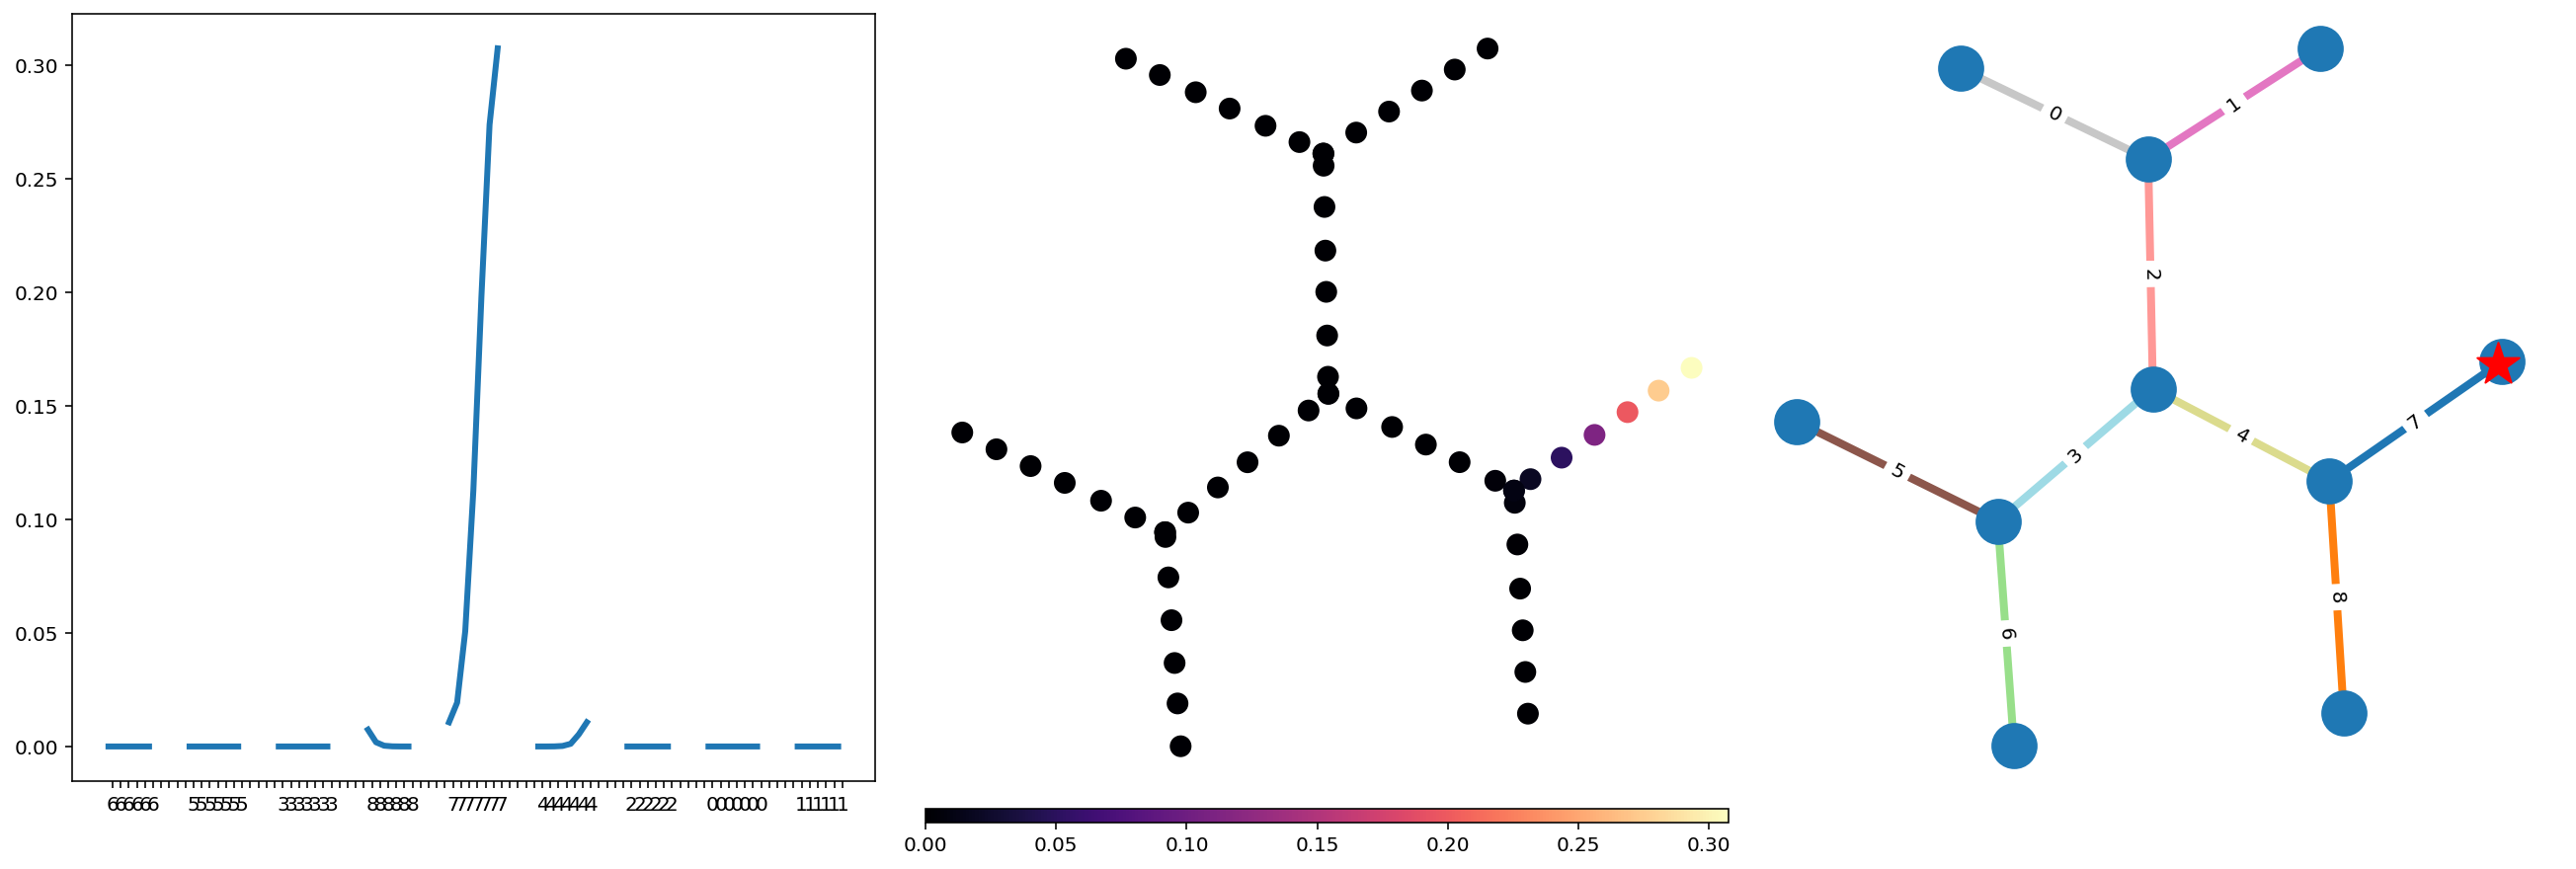

In [143]:
bin_ind = 48

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

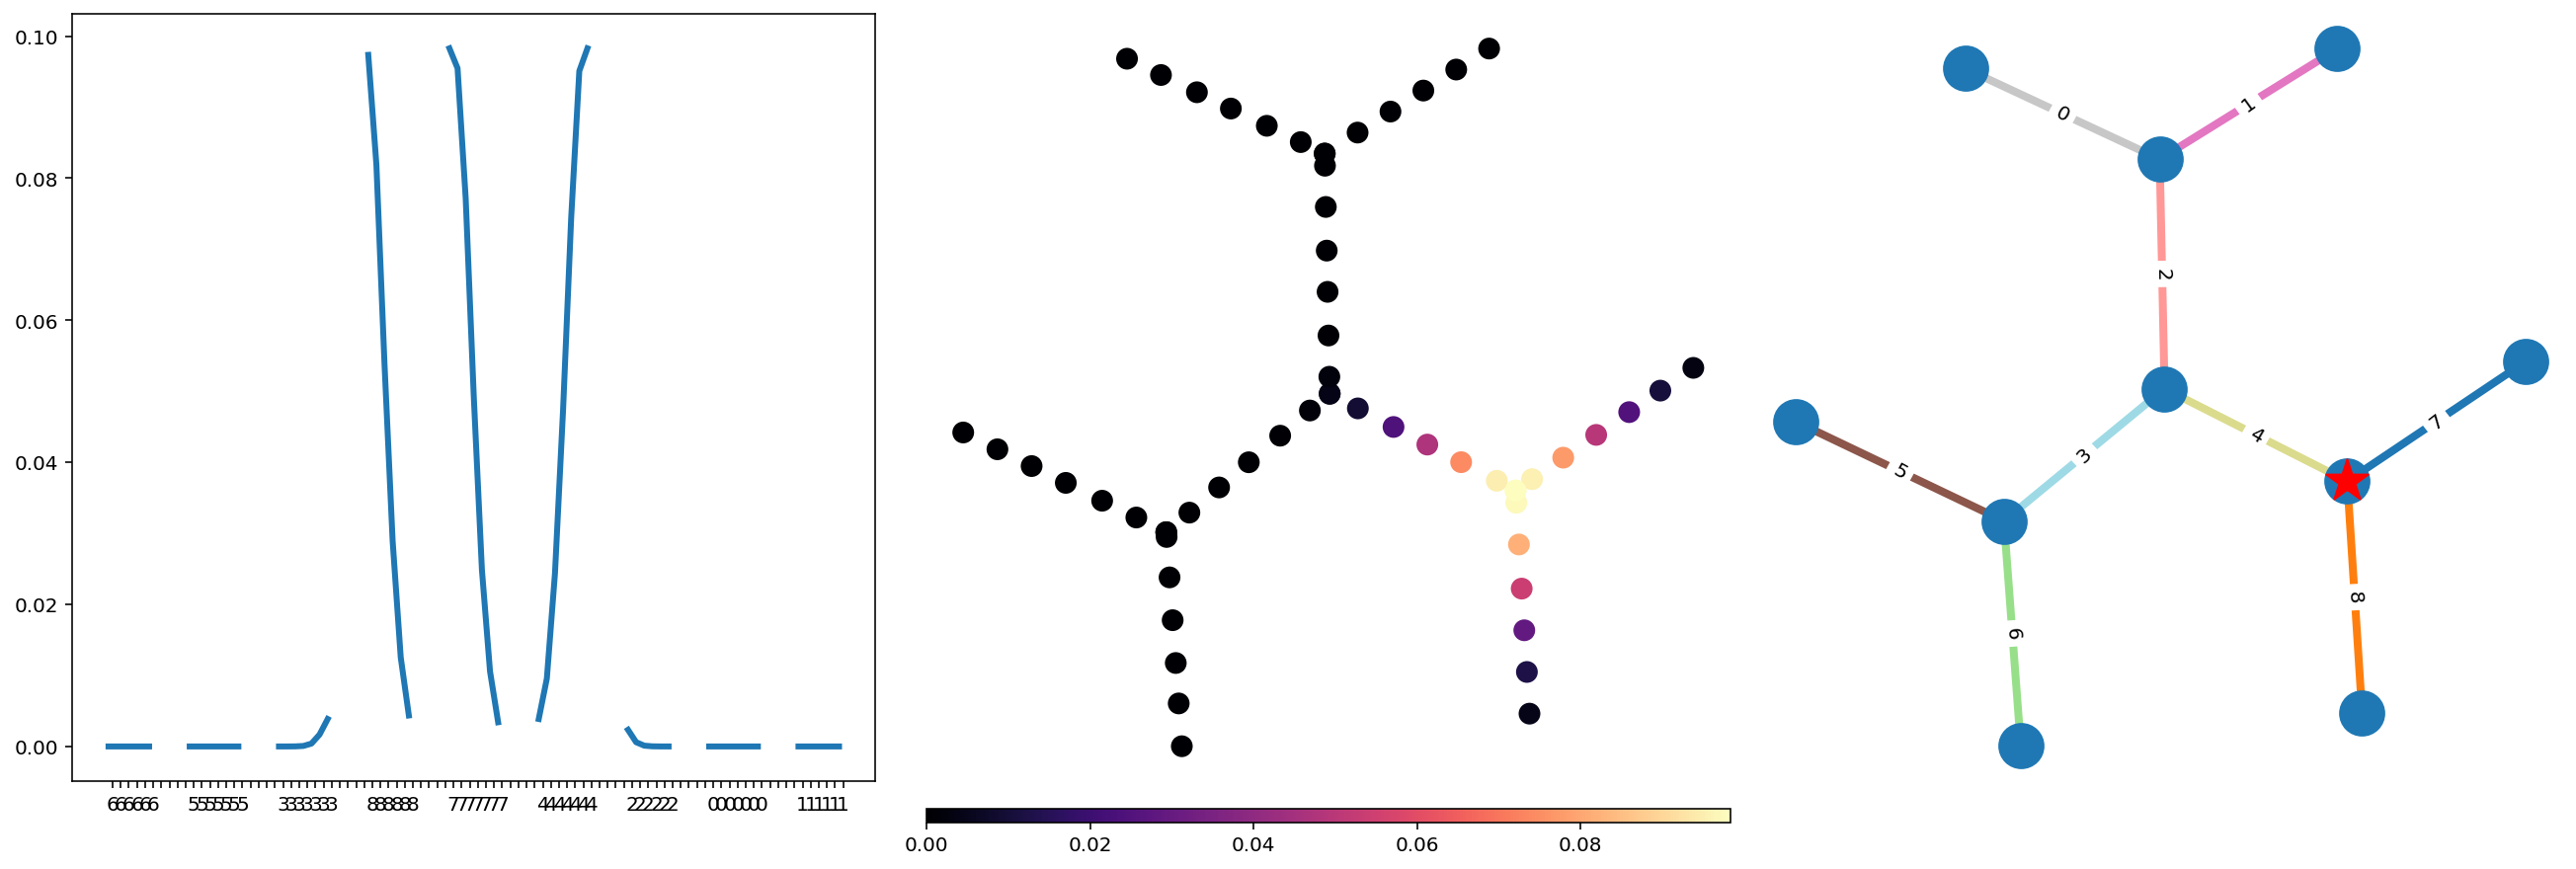

In [144]:
bin_ind = 42

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

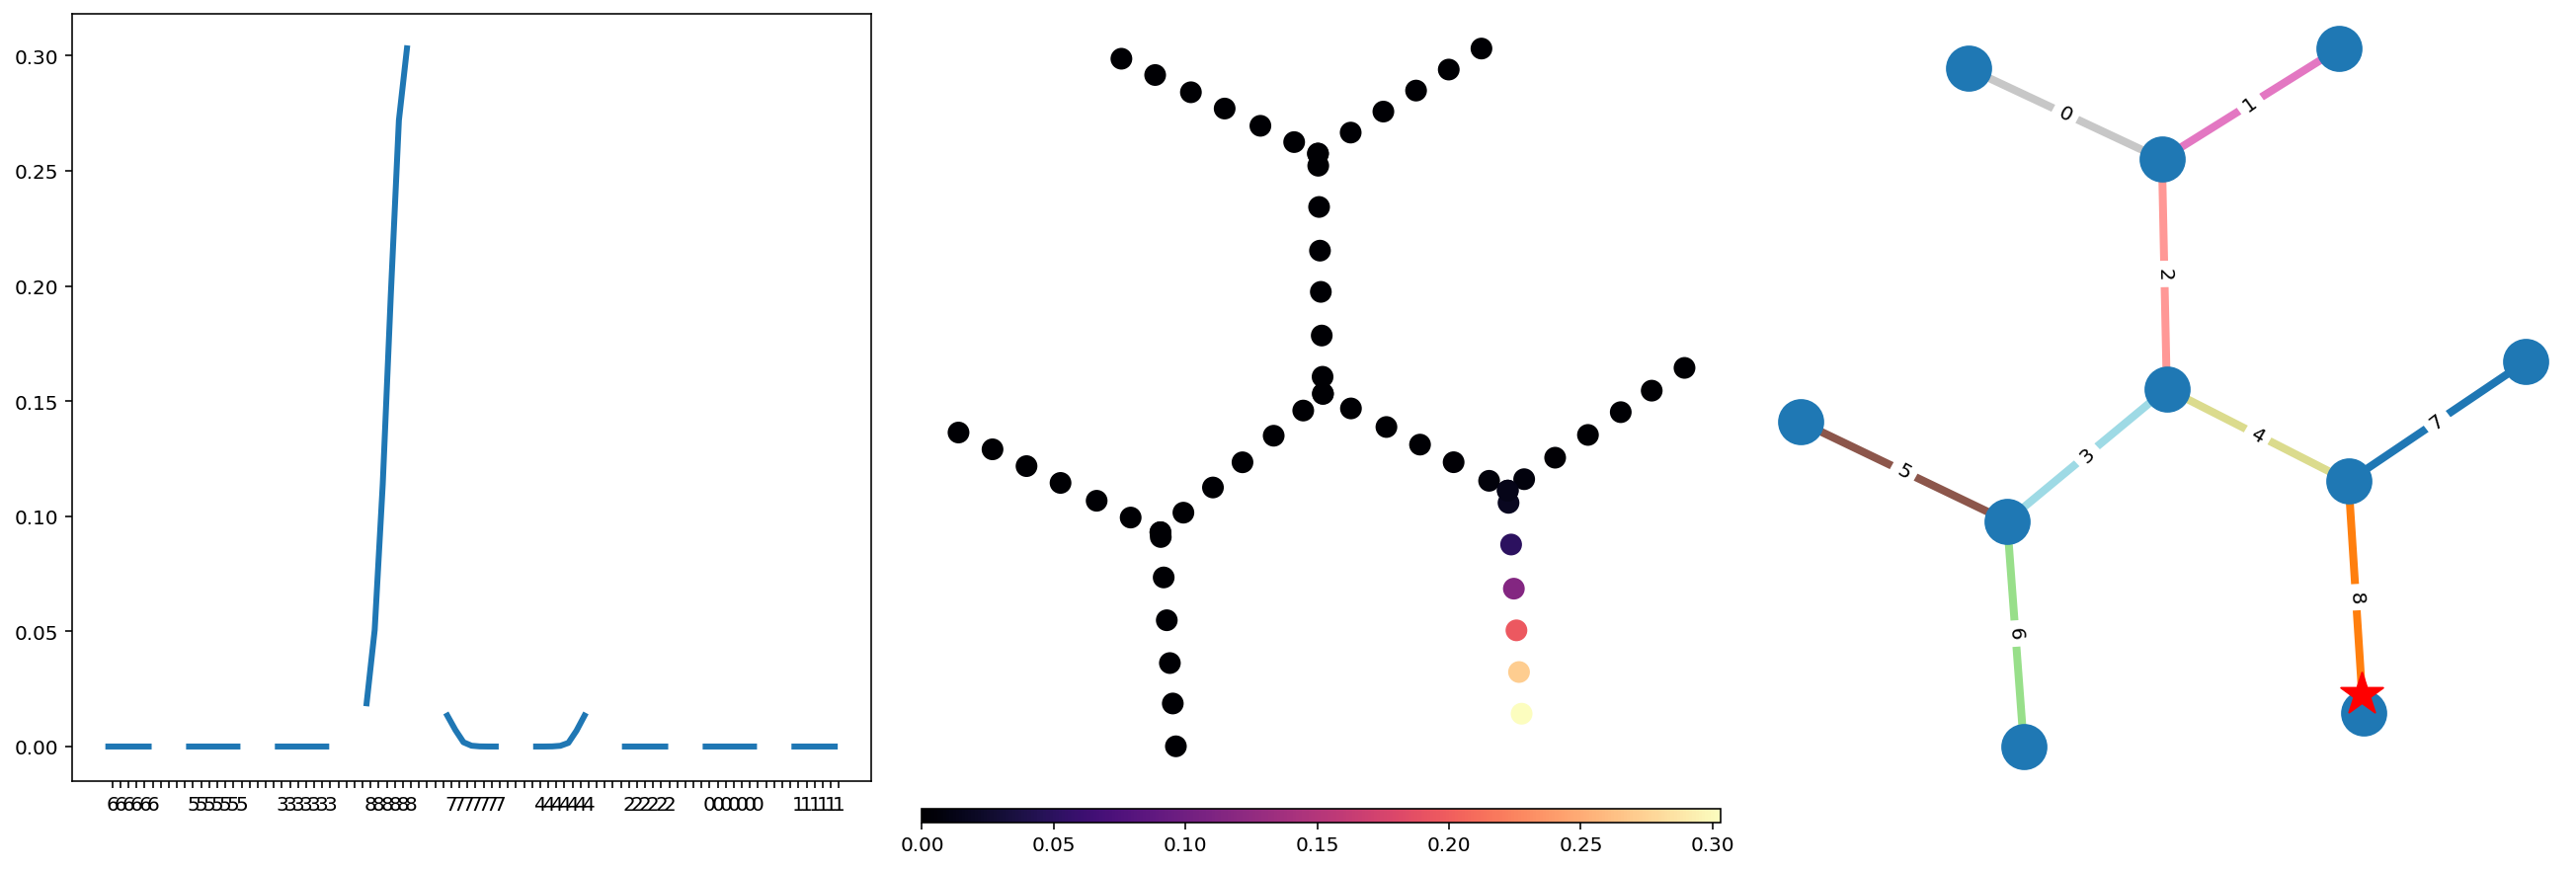

In [145]:
bin_ind = 37

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

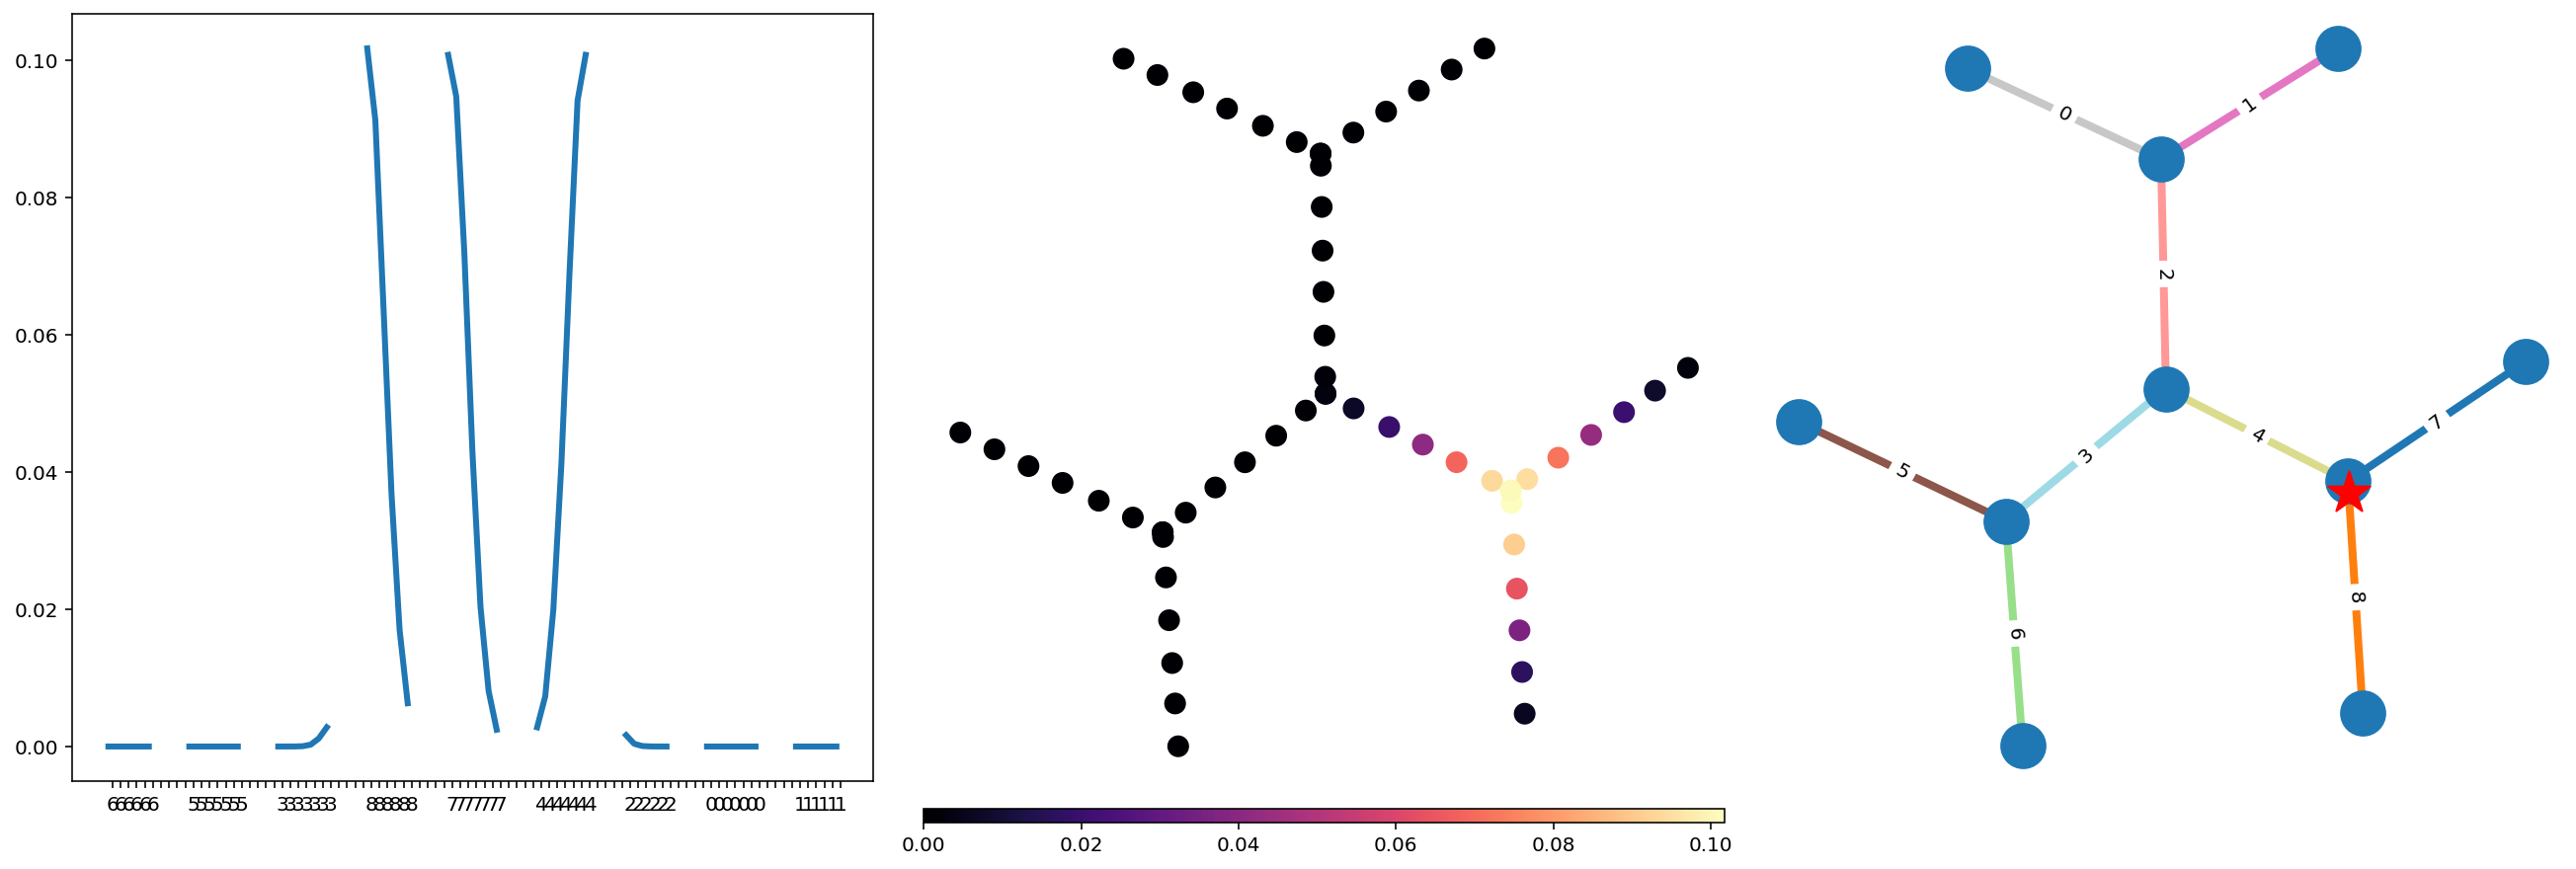

In [146]:
bin_ind = 32

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

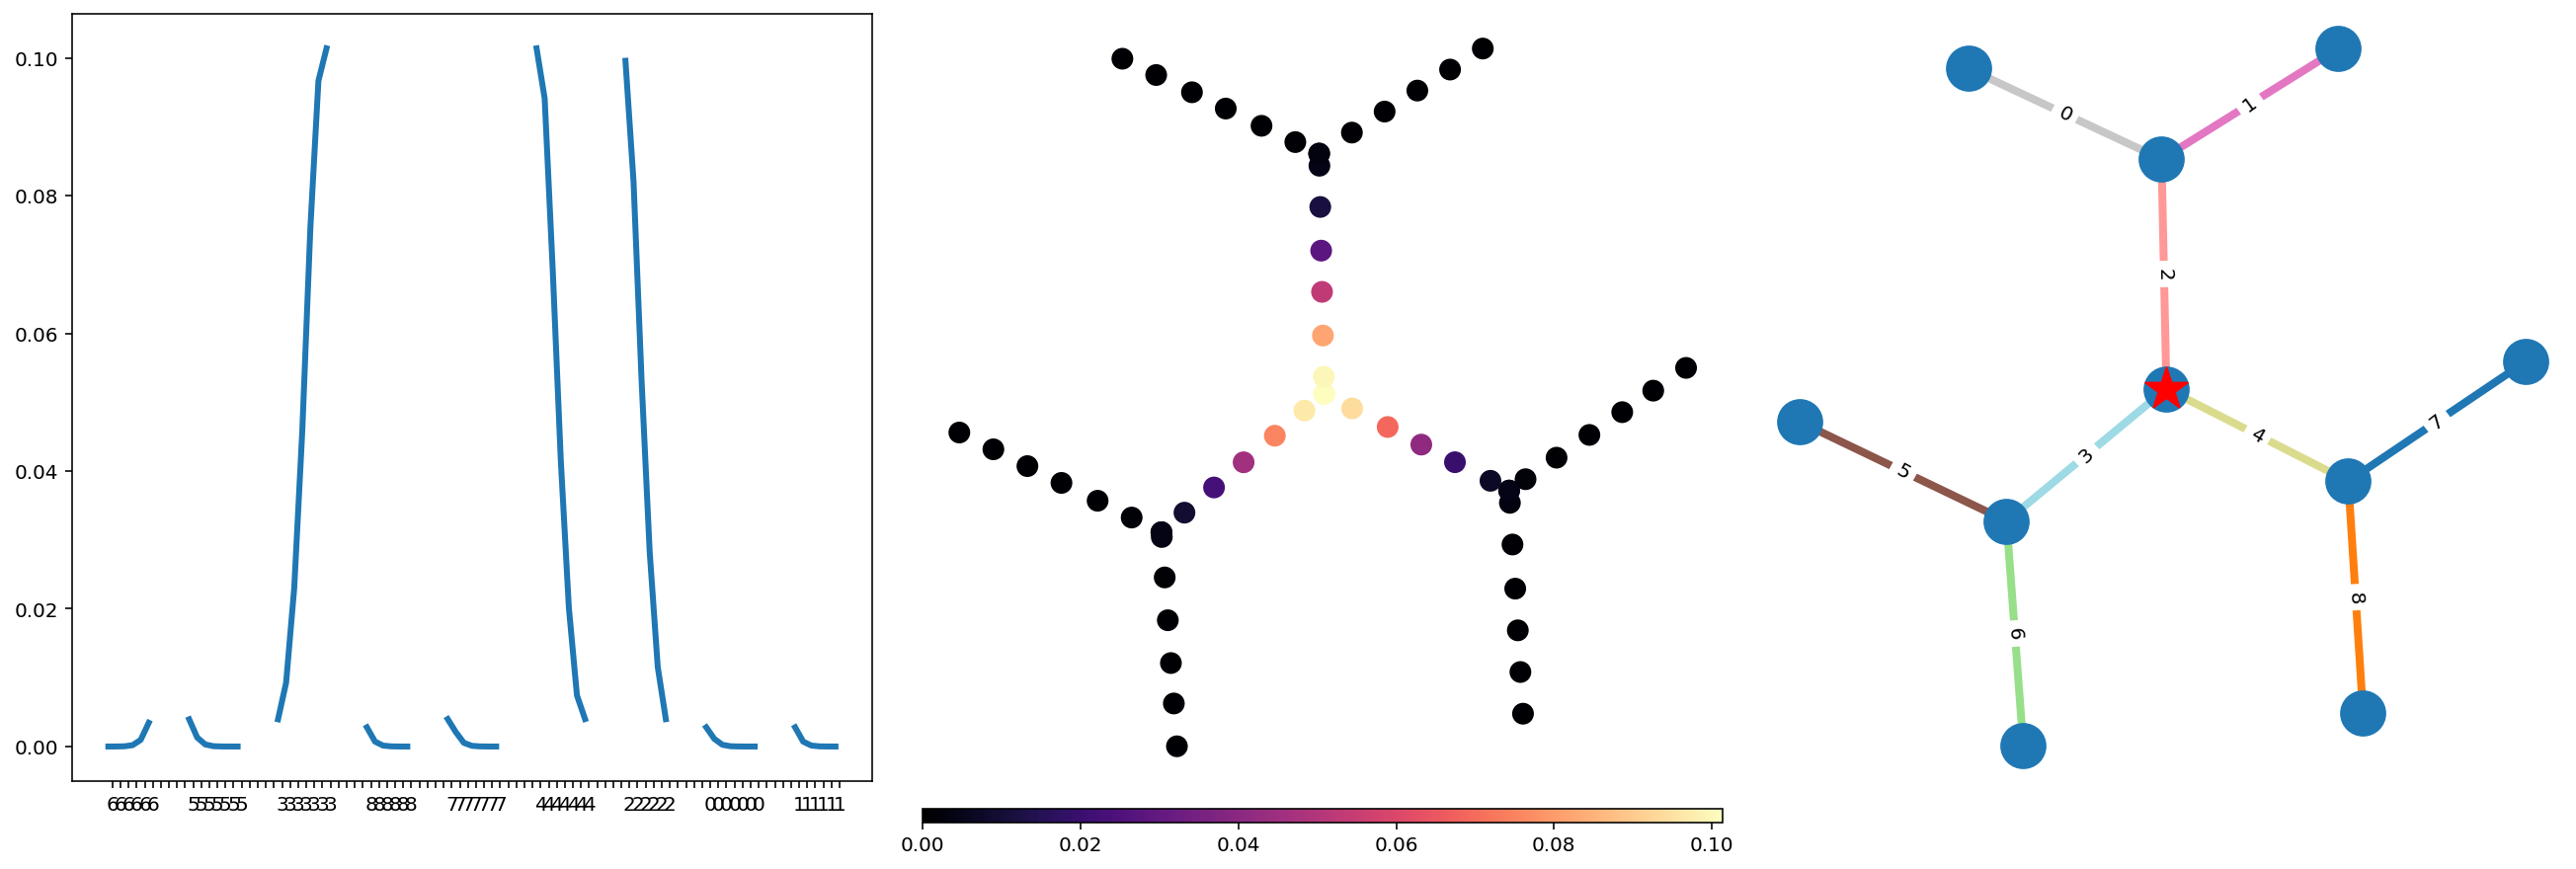

In [147]:
bin_ind = 27

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

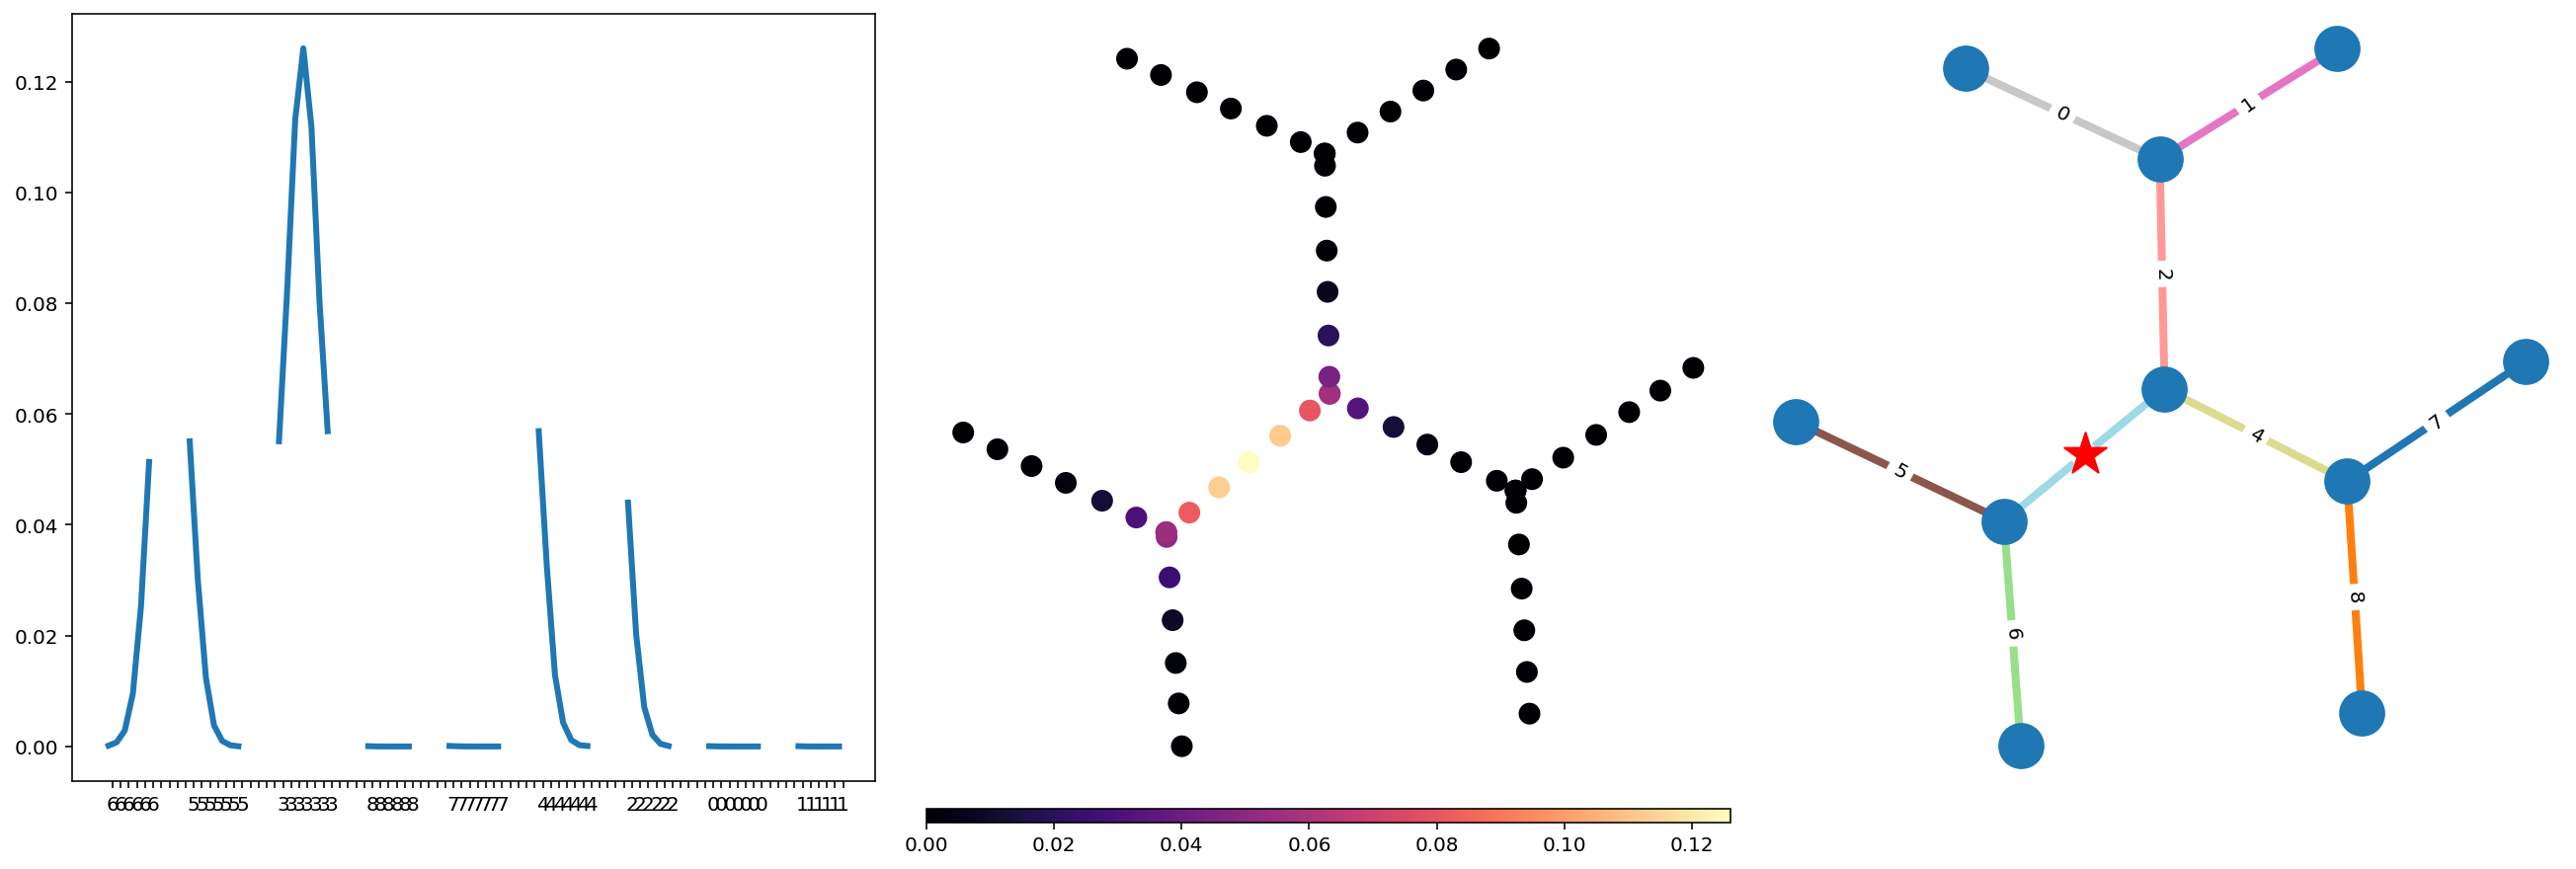

In [148]:
bin_ind = 24

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

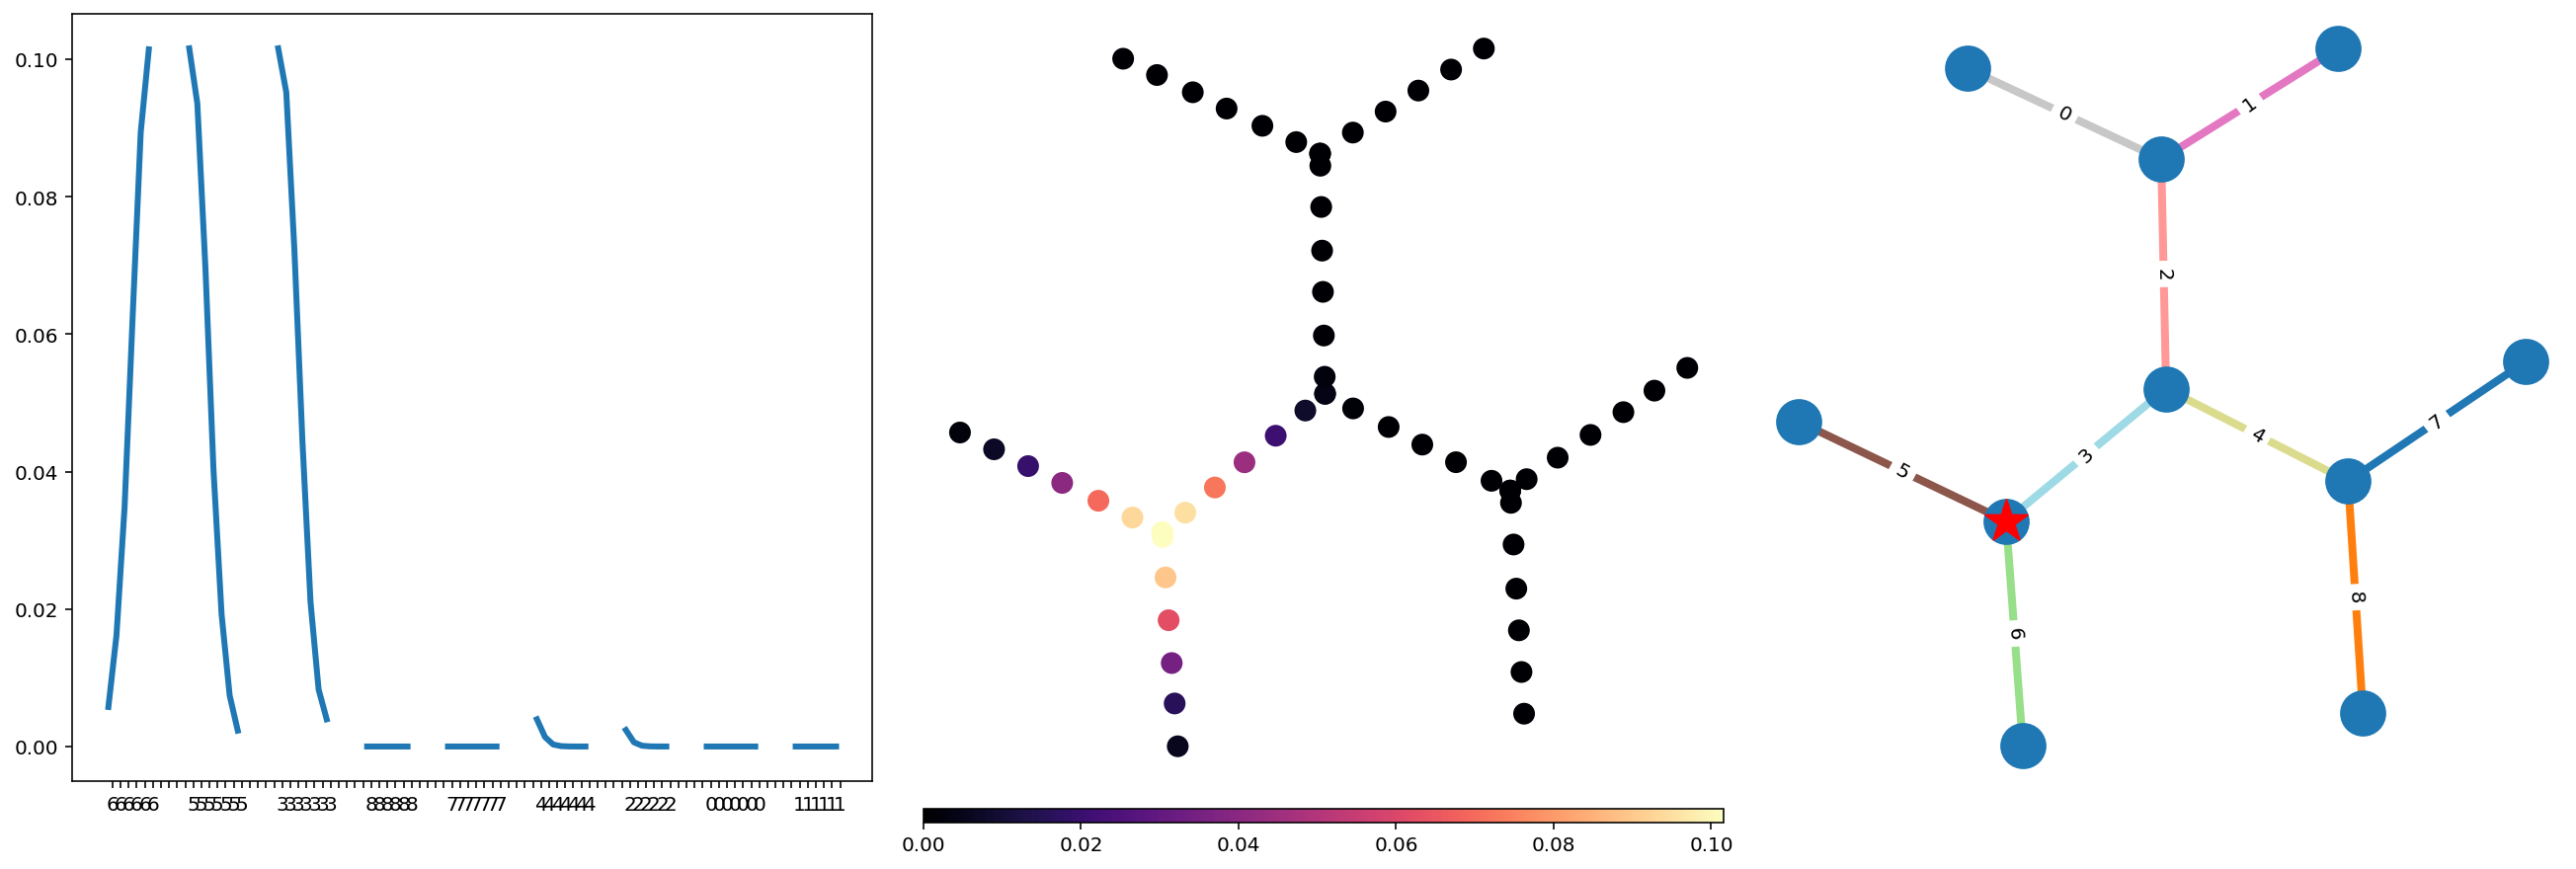

In [149]:
bin_ind = 21

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

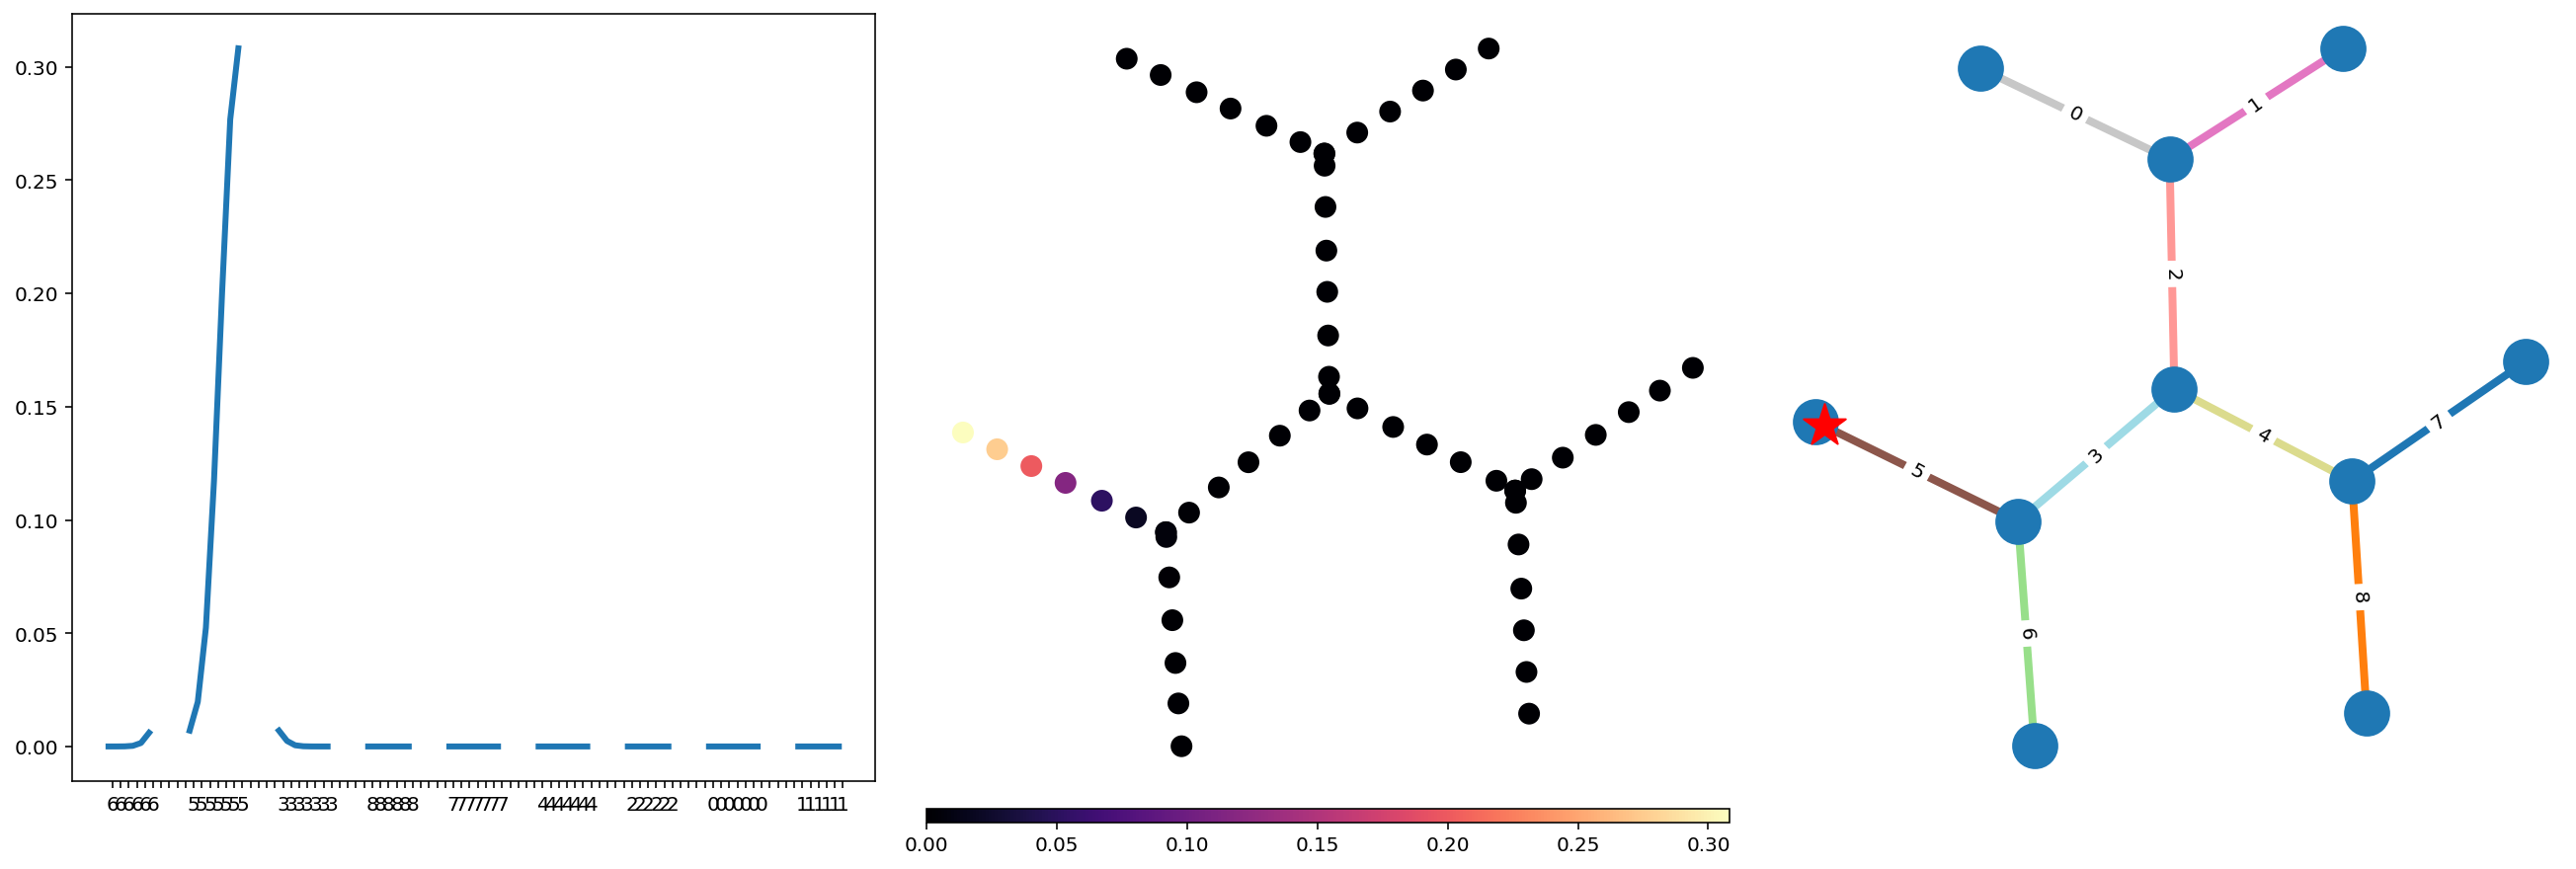

In [150]:
bin_ind = 16

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

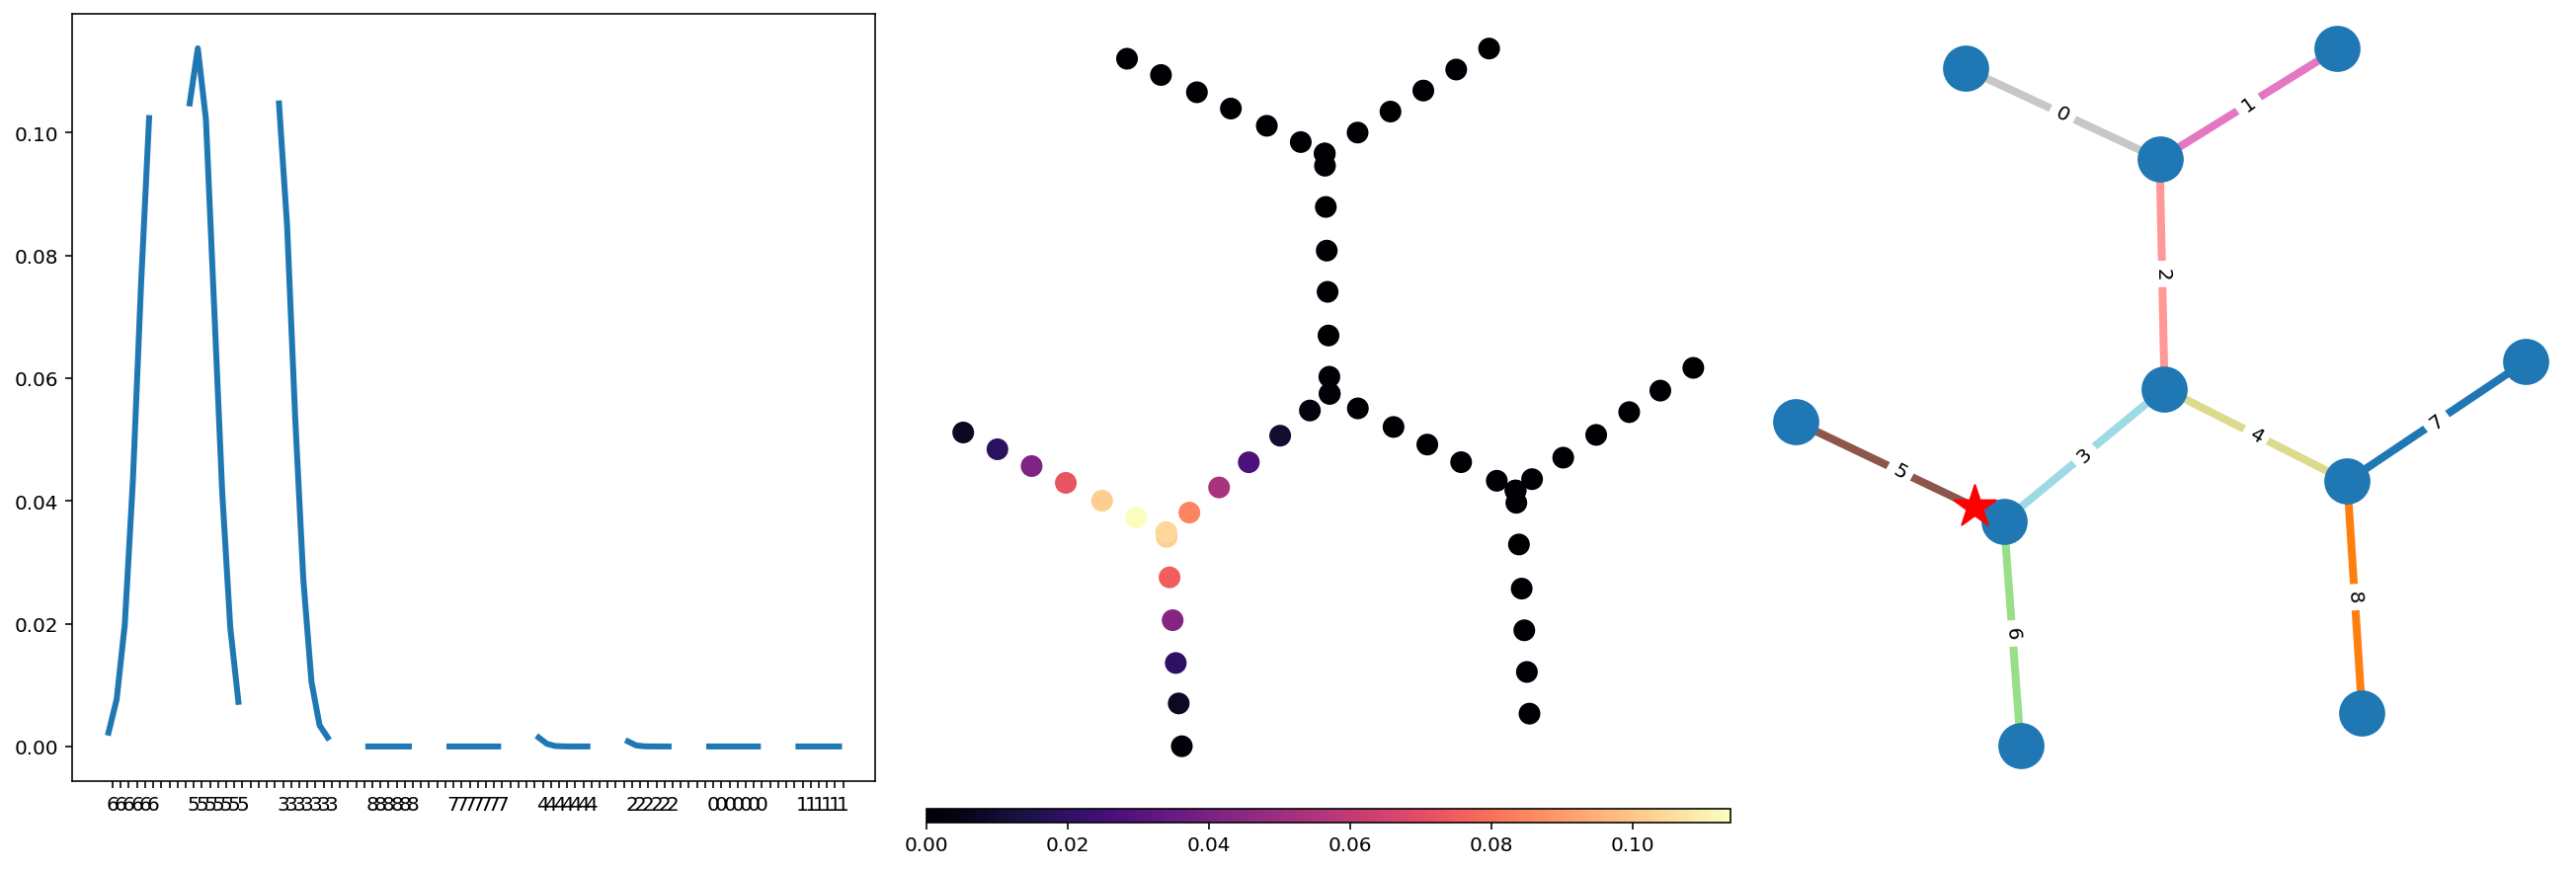

In [151]:
bin_ind = 11

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

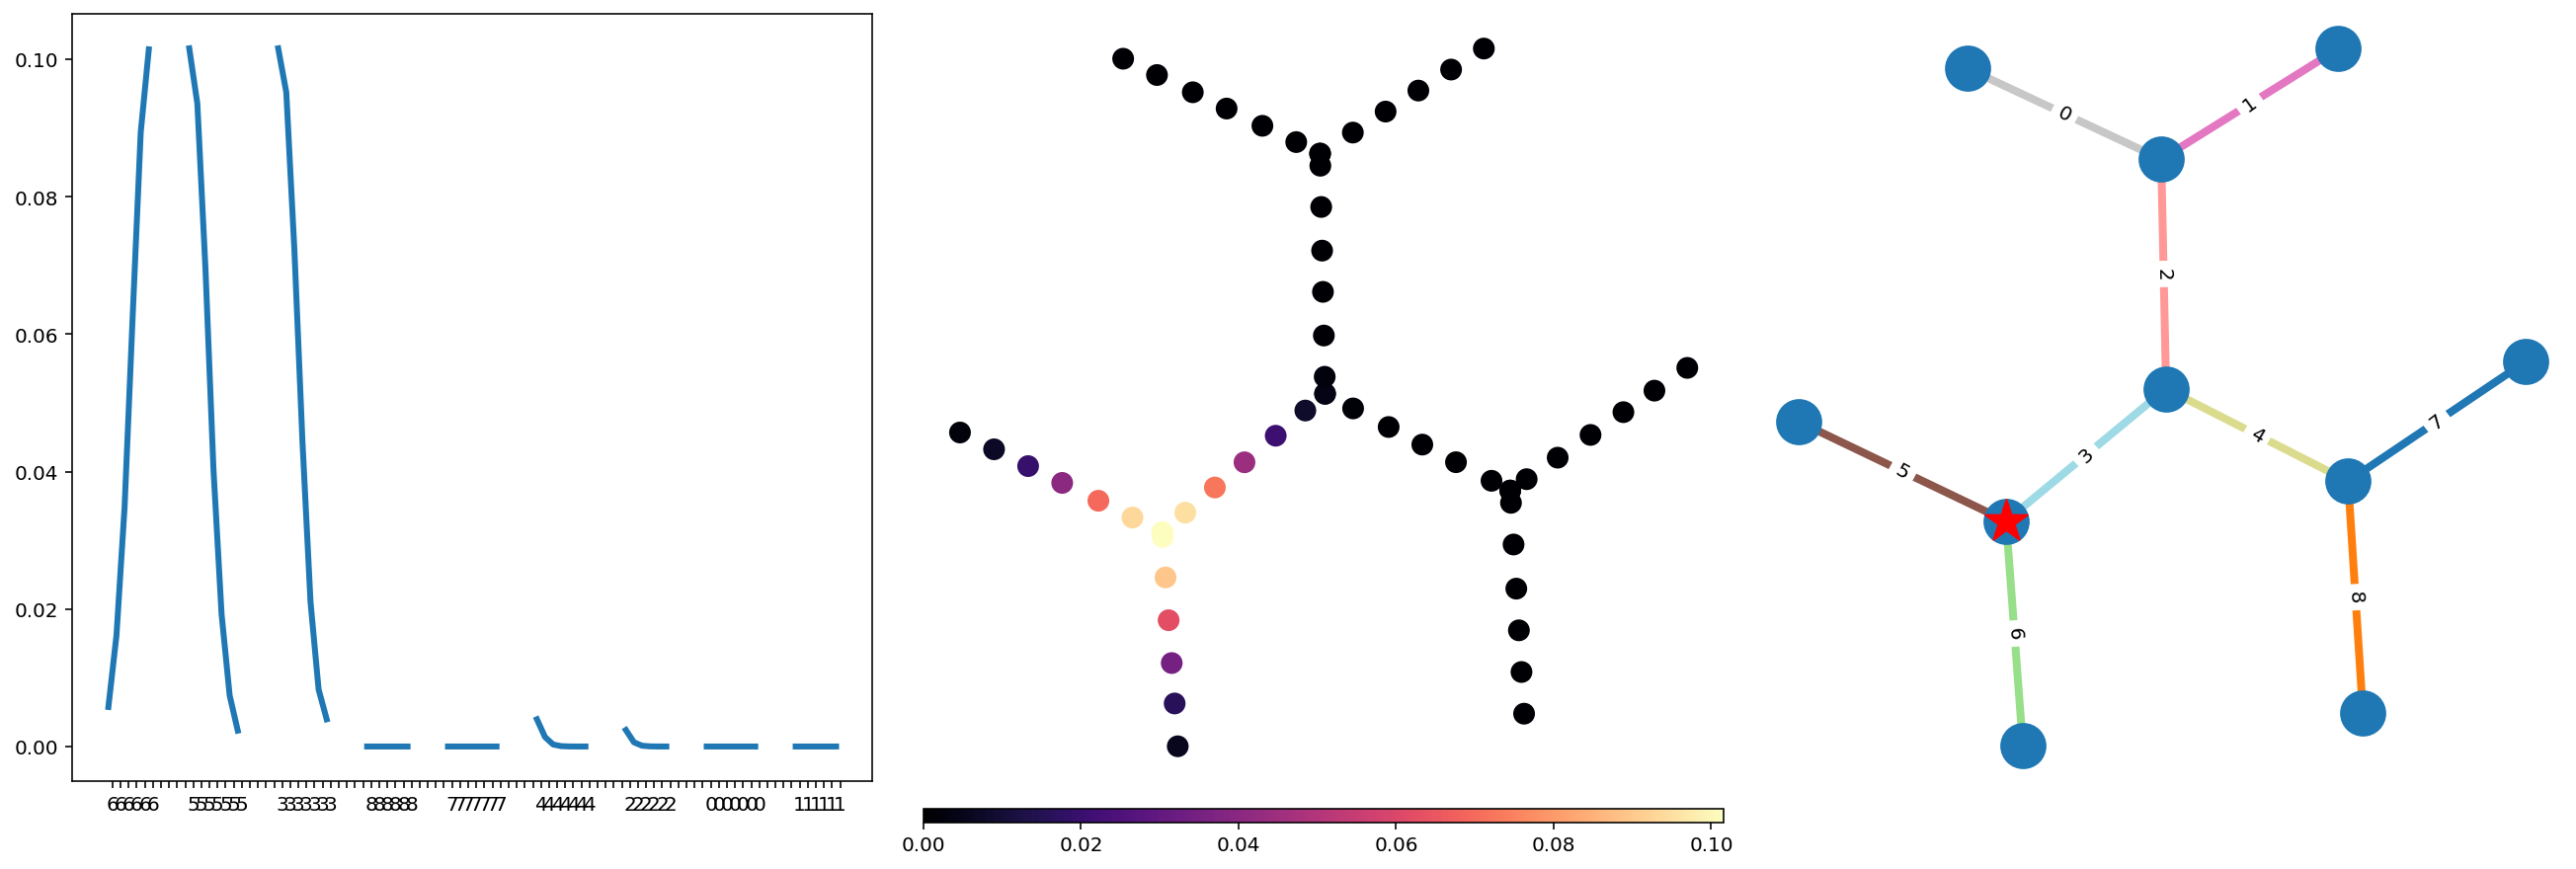

In [152]:
bin_ind = 10

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

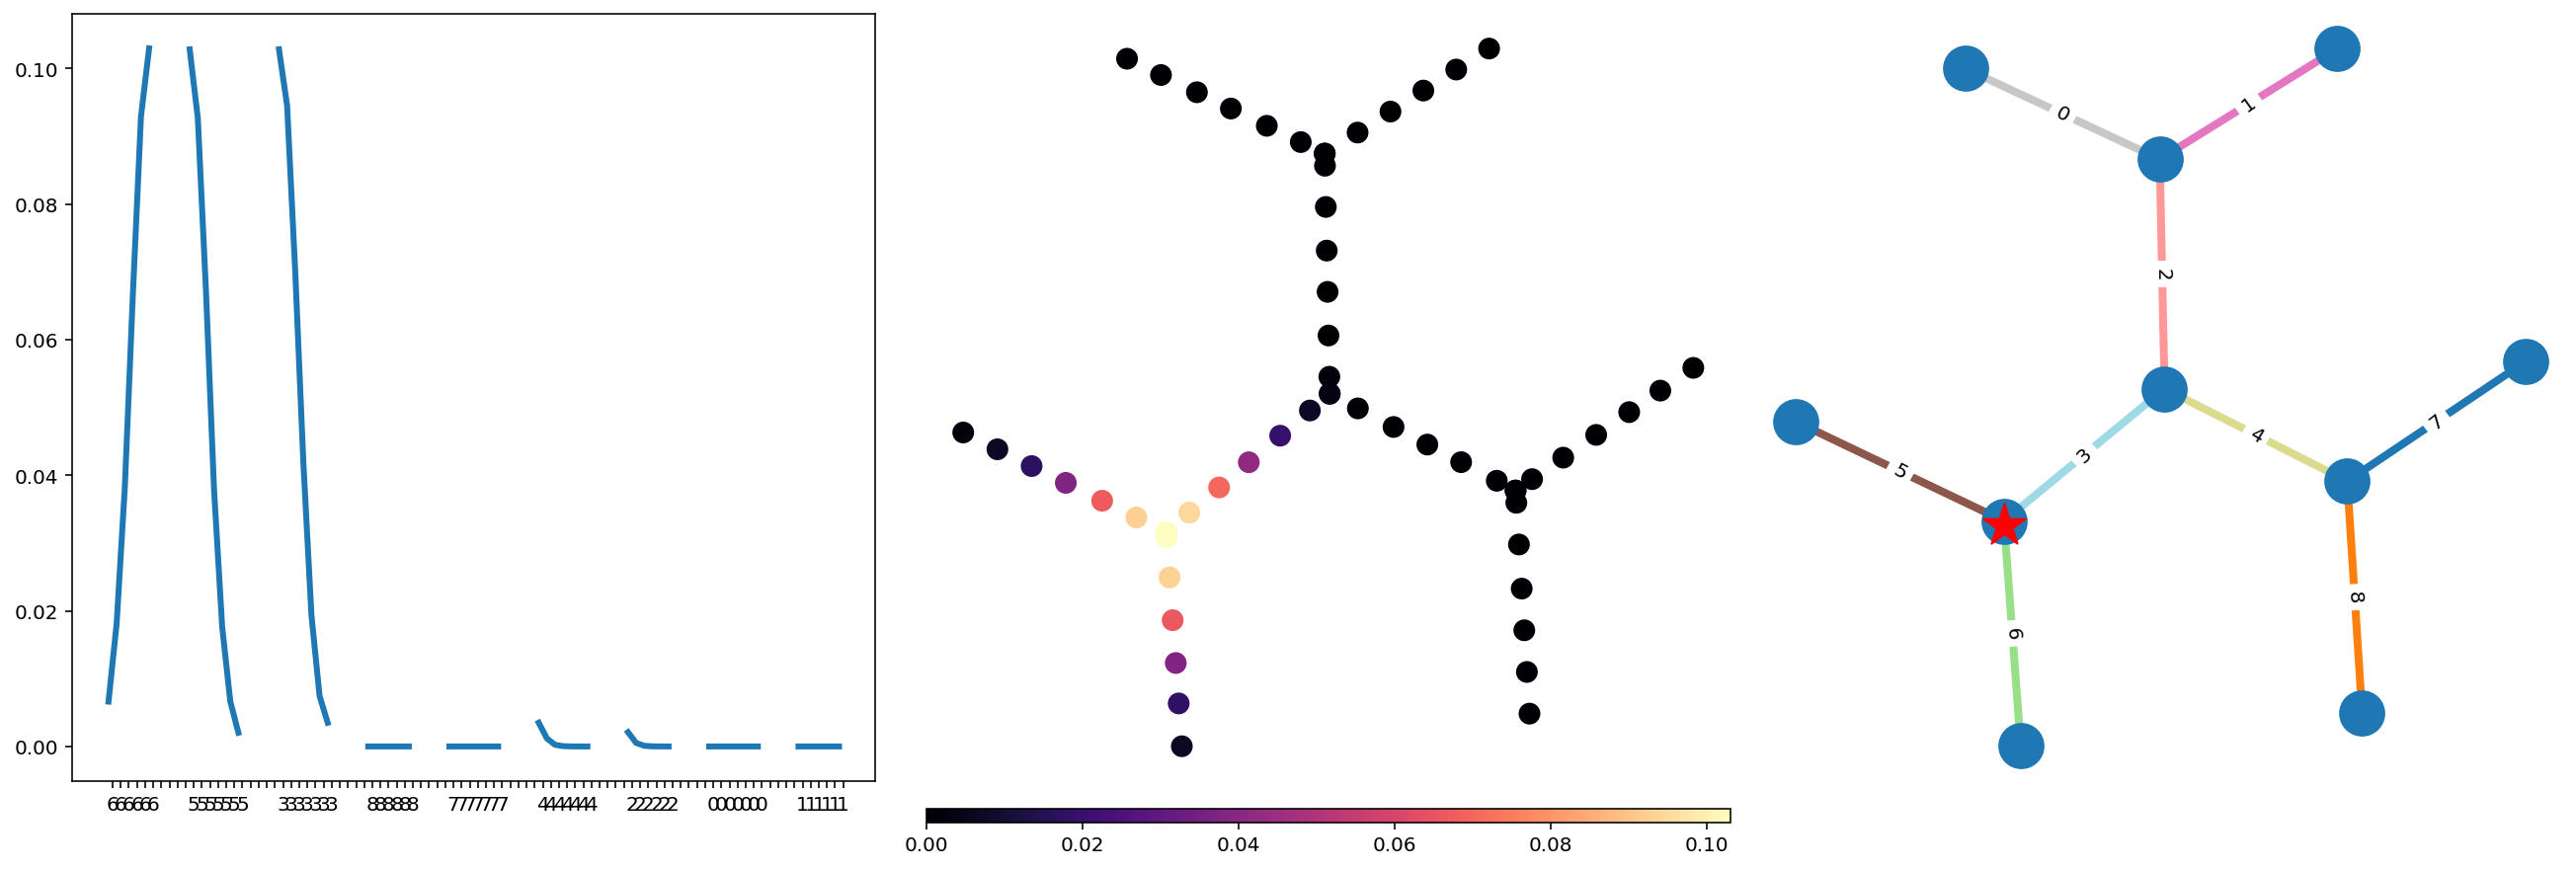

In [153]:
bin_ind = 5

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');

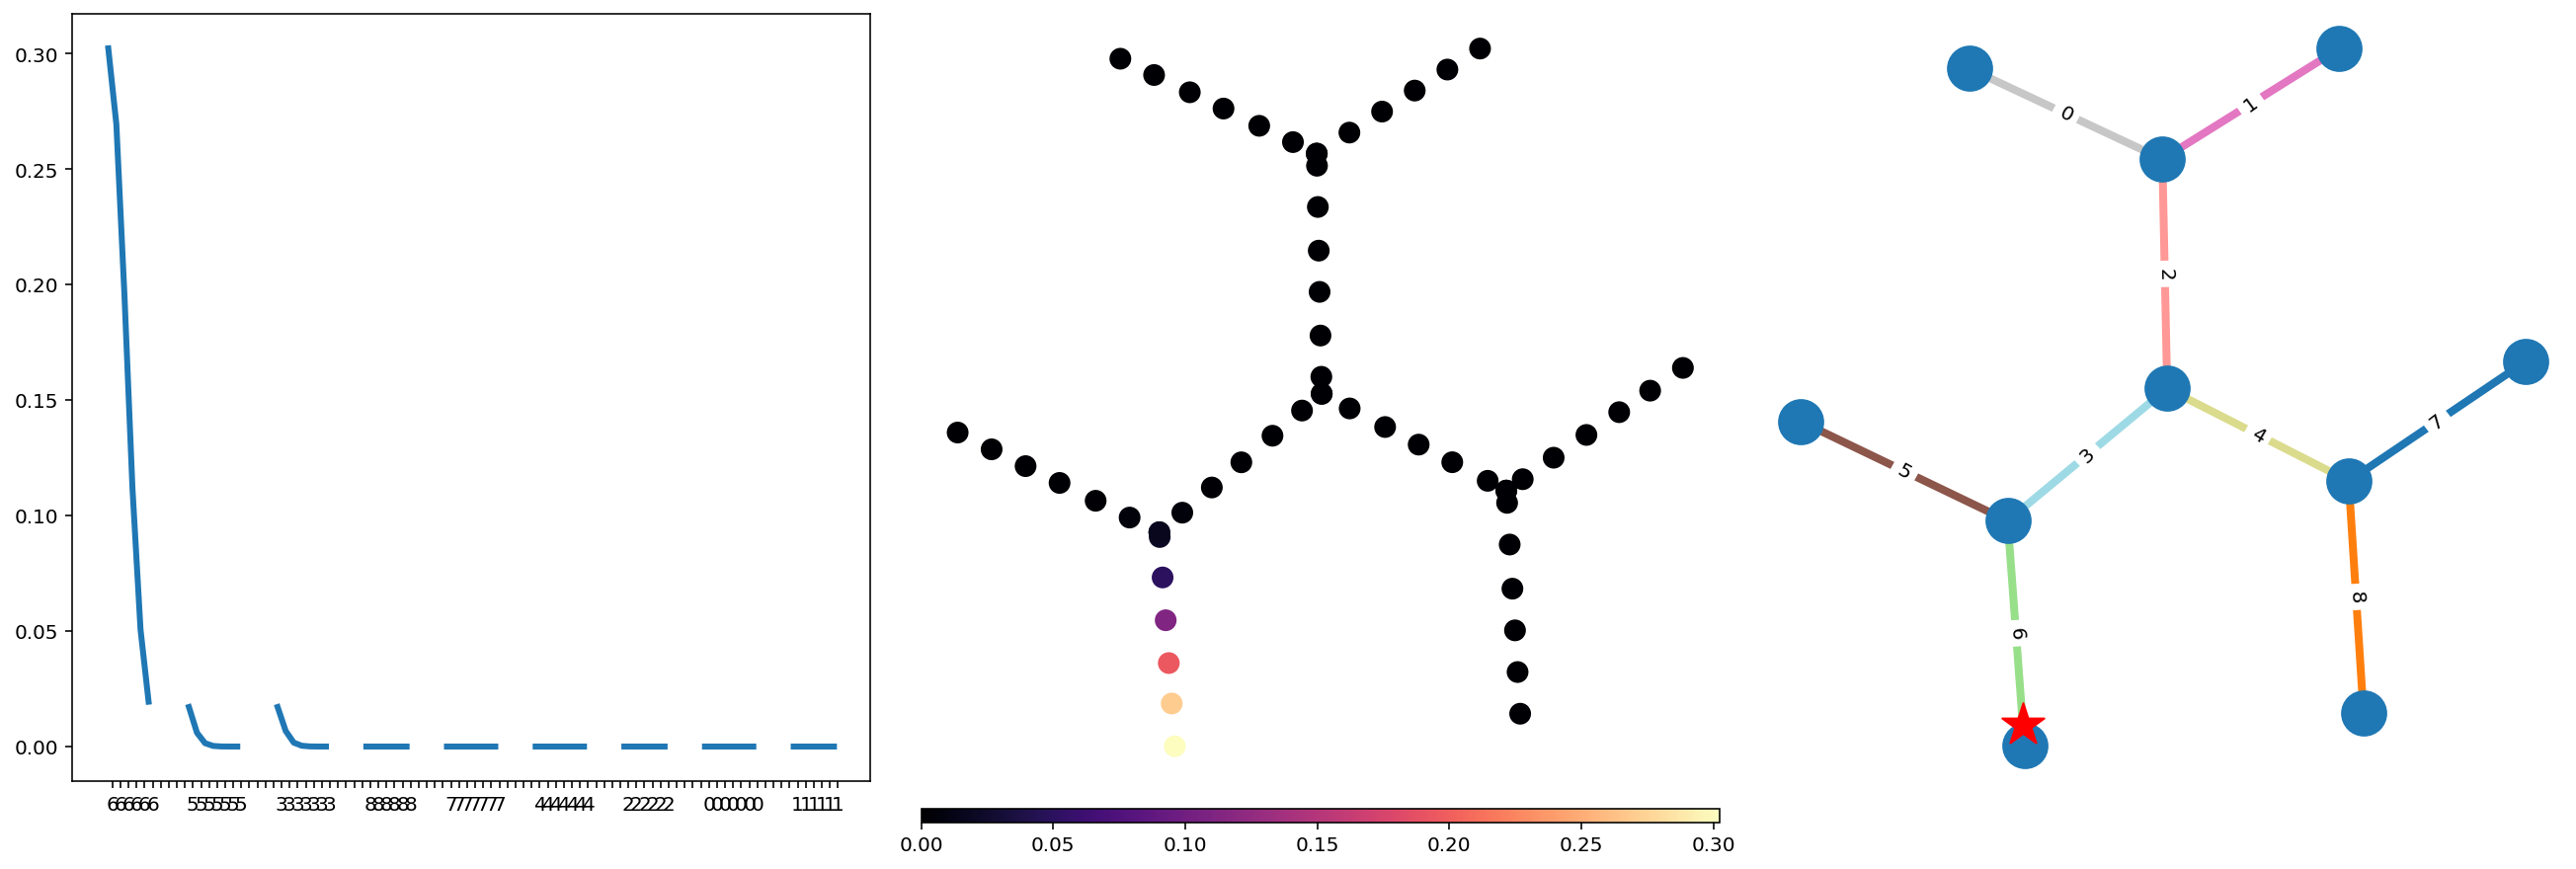

In [154]:
bin_ind = 0

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
axes[0].set_xticklabels(bin_edge)

m = axes[1].scatter(place_bin_centers_2D[:, 0], place_bin_centers_2D[:, 1],
                    c=state_transition[bin_ind][decoder.is_track_interior_],
                    s=100, cmap='magma', vmin=0.00)
axes[1].axis('off')
plt.colorbar(m, ax=axes[1], orientation='horizontal')

node_position = nx.get_node_attributes(track_graph, 'pos')
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(track_graph, node_position, ax=axes[2],
                 edge_color=EDGE_ORDER, width=4, alpha=1,
                 edge_cmap=plt.get_cmap('tab20'), with_labels=False,
                 node_size=500)
nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[2], edge_labels=edge_labels);
x,y = track_graph1.nodes[node_to_bin[bin_ind]]['pos']
axes[2].scatter(x, y, s=500, zorder=200, color='red', marker='*')
axes[2].axis('off');